# Utility functions

## Model hooks

In [1]:
from types import MethodType
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"] = "serif" 

class AttnHack:
    # this is a hack that allows us to get intermediate values used in attention
    # what we're doing here is copy-and-pasting the attention code, but adding in some lines that grab
    # the values that we want
    # credit to https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt_neo/modeling_gpt_neo.py
    def __init__(self, module):
        self.original_attn_method = module._attn
        self.module = module
    def attach(self, out_dict):
        def my_attn(self, query, key, value, attention_mask=None, head_mask=None):
            # Keep the attention weights computation in fp32 to avoid overflow issues
            query = query.to(torch.float32)
            key = key.to(torch.float32)
    
            attn_weights = torch.matmul(query, key.transpose(-1, -2))
    
            query_length, key_length = query.size(-2), key.size(-2)
            causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
            mask_value = torch.finfo(attn_weights.dtype).min
            # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
            # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
            mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
            attn_weights = torch.where(causal_mask, attn_weights, mask_value)

            out_dict['attn_raw_weights'] = attn_weights
            out_dict['attn_mask'] = attention_mask
            out_dict['head_mask'] = head_mask
    
            if attention_mask is not None:
                # Apply the attention mask
                attn_weights = attn_weights + attention_mask
        
            attn_weights = nn.functional.softmax(attn_weights, dim=-1)
            attn_weights = attn_weights.to(value.dtype)
            attn_weights = self.attn_dropout(attn_weights)
    
            # Mask heads if we want to
            if head_mask is not None:
                attn_weights = attn_weights * head_mask
    
            attn_output = torch.matmul(attn_weights, value)
    
            return attn_output, attn_weights
        self.module._attn = MethodType(my_attn, self.module)
    def remove(self):
        self.module._attn = self.original_attn_method

def attach_hooks(model):
    hooks = []
    out_list = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    
    def make_hook(hook_name, out_dict, is_input=False):
        def my_hook(model, input, output):
            if is_input:
                out_dict[hook_name] = input[0]
            else:
                out_dict[hook_name] = output
        return my_hook
        
    for l in range(len(model.transformer.h)):
        hooks.append(model.transformer.h[l].register_forward_hook(
            make_hook("block_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].mlp.register_forward_hook(
            make_hook("mlp_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].mlp.register_forward_hook(
            make_hook("mlp_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].ln_2.register_forward_hook(
            make_hook("ln_2_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].attn.register_forward_hook(
            make_hook("attn_in", out_list['layers'][l], is_input=True)
        ))
        hooks.append(model.transformer.h[l].attn.register_forward_hook(
            make_hook("attn_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.q_proj.register_forward_hook(
            make_hook("q_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.k_proj.register_forward_hook(
            make_hook("k_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].attn.attention.v_proj.register_forward_hook(
            make_hook("v_proj_out", out_list['layers'][l])
        ))
        hooks.append(model.transformer.h[l].ln_1.register_forward_hook(
            make_hook("ln_1_in", out_list['layers'][l], is_input=True)
        ))
        # now, hook on the attention hacks
        hack = AttnHack(model.transformer.h[l].attn.attention)
        hack.attach(out_list['layers'][l])
        hooks.append(hack)
    hooks.append(model.transformer.ln_f.register_forward_hook(
        make_hook("ln_f_in", out_list, is_input=True)
    ))
    hooks.append(model.lm_head.register_forward_hook(
        make_hook("lm_out", out_list)
    ))
        
    return out_list, hooks

In [2]:
def run_with_patched_activations(model, prompt, patch_dicts, pre_tokenized=False, return_np=False, np_patch=None):
    # patch_dicts: a list of dicts
    # each patched activation dict has format {'layer', 'sublayer', 'token', 'patch'}
    # currently-supported sublayers: ln_1_in, ln_2_in, attn_in, mlp_in

    if np_patch is None: np_patch = return_np
    # create and attach all hooks
    out_list, read_hooks = attach_hooks(model)
    write_hooks = []
    def make_write_hook(token, patch, my_np_patch):
        def my_hook(model, input):
            # TODO: do we have to clone input?
            if my_np_patch:
                input[0][0,token,:] = torch.from_numpy(patch)
            else:
                input[0][0,token,:] = patch
            return input
        return my_hook
    for patch_dict in patch_dicts:
        cur_layer = model.transformer.h[patch_dict['layer']]
        if patch_dict['sublayer'] == 'ln_1_in':
            cur_module = cur_layer.ln_1
        elif patch_dict['sublayer'] == 'attn_in':
            cur_module = cur_layer.attn
        elif patch_dict['sublayer'] == 'ln_2_in':
            cur_module = cur_layer.ln_2
        elif patch_dict['sublayer'] == 'mlp_in':
            cur_module = cur_layer.mlp
        write_hooks.append(cur_module.register_forward_pre_hook(
            make_write_hook(patch_dict['token'], patch_dict['patch'], np_patch)
        ))

    if pre_tokenized:
        tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
    else:
        tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    model(**tokens)
    for hook in read_hooks: hook.remove()
    for hook in write_hooks: hook.remove()
    if return_np:
        out_list = embeddings_torch_to_np(out_list)
    return out_list

## Memory efficiency

In [3]:
import gc
def get_num_tensors():
    tensors_count = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.device.type == "cuda":
                tensors_count += 1
        except:
            pass
    return tensors_count

In [4]:
def do_free():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
def free_embeddings(embeddings):
    l = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            embeddings['layers'][0][key] = None
        embeddings['layers'][0] = None
        del embeddings['layers'][0]
        del key
        del val
    embeddings['layers'] = None
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
def _convert_embeddings(embeddings, convert_func, free=True):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    for l in range(len(embeddings['layers'])):
        #print(f"Layer {l} num tensors before: {get_num_tensors()}")
        for key, val in embeddings['layers'][l].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                my_l = []
                for x in val:
                    if type(x) is tuple:
                        my_l.append(tuple(convert_func(y) for y in x))
                    else:
                        my_l.append(convert_func(x))
                new_embeddings['layers'][l][key] = tuple( my_l )
                while len(my_l) > 0:
                    my_l[0] = None
                    del my_l[0]
                del my_l
            else:
                new_embeddings['layers'][l][key] = convert_func(val)
    new_embeddings['ln_f_in'] = convert_func(embeddings['ln_f_in'])
    new_embeddings['lm_out'] = convert_func(embeddings['lm_out'])
    if free:
        free_embeddings(embeddings)
        del embeddings
        del x, key, val
        do_free()
    return new_embeddings
def embeddings_torch_to_np(embeddings, free=True):
    return _convert_embeddings(embeddings, lambda x: x.detach().cpu().numpy(), free=free)
def embeddings_np_to_torch(embeddings, free=True):
    return _convert_embeddings(embeddings, lambda x: torch.from_numpy(x).to("cuda"), free=free)

In [5]:
def embeddings_torch_to_cpu(embeddings):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                new_embeddings['layers'][l][key] = (x.detach().cpu() for x in val)
            else:
                new_embeddings['layers'][l][key] = val.detach().cpu()
            embeddings['layers'][0][key] = None
            #do_free()
        embeddings['layers'][0] = None
        del embeddings['layers'][0]  
        l += 1
    embeddings['layers'] = None
    new_embeddings['ln_f_in'] = embeddings['ln_f_in'].detach().cpu()
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
    return new_embeddings

def embeddings_torch_to_gpu(embeddings):
    new_embeddings = {"layers": [ {} for l in range(len(model.transformer.h)) ]}
    l = 0
    while len(embeddings['layers']) > 0:
        for key, val in embeddings['layers'][0].items():
            if val is None:
                new_embeddings['layers'][l][key] = None
            elif type(val) is tuple:
                new_embeddings['layers'][l][key] = (x.to("cuda") for x in val)
            else:
                new_embeddings['layers'][l][key] = val.to("cuda")
            embeddings['layers'][0][key] = None
            #do_free()
        embeddings['layers'][0] = None
        del embeddings['layers'][0]
        l += 1
    embeddings['layers'] = None
    new_embeddings['ln_f_in'] = embeddings['ln_f_in'].to("cuda")
    embeddings['ln_f_in'] = None
    embeddings = None
    do_free()
    return new_embeddings

## Range normal setup

In [6]:
vocab_size = 50257
import torch
import torch.nn.functional as F
import torch.nn as nn

def make_lm_head_normal(pos_list, neg_list, normalize=False, take_first_token=False):
    n = torch.zeros(vocab_size)
    for tok in pos_list:
        if not take_first_token:
            n += F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
        else:
            n += F.one_hot(torch.tensor(tokenizer(tok).input_ids[0]),vocab_size)
    for tok in neg_list:
        if not take_first_token:
            n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
        else:
            n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids[0]),vocab_size)
    if normalize:
        n = n/torch.linalg.norm(n)
    return n

def make_range_normal(pos_list, neg_list, normalize=False):
    n = torch.zeros(vocab_size)
    for tok in pos_list:
        n += F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
    for tok in neg_list:
        n -= F.one_hot(torch.tensor(tokenizer(tok).input_ids),vocab_size)[0]
    print(n.shape)
    n = n.T.to("cuda", dtype=torch.float32)
    n = model.lm_head.weight.data.T @ n
    if normalize:
        n = n/torch.linalg.norm(n)
    return n

## Nonlinear approximation

In [7]:
import mdmm
# find point on domain boundary closest to our starting point using mdmm constrained optimization library
def torch_domain_boundary_proj(x_0, f, range_normal, range_affine, lr=0.01, eps=0.0001):
    x_0 = x_0.detach()
    x = x_0.detach().clone().to("cuda")
    x.requires_grad_(True)
    
    constraint = mdmm.EqConstraint(lambda: torch.dot(range_normal, f(x)-range_affine),0)
    mdmm_module = mdmm.MDMM([constraint])
    
    optimizer = mdmm_module.make_optimizer([x], lr=lr)
    
    loss = None
    prev_loss = None
    while loss is None or abs(loss.item()) > eps:
        prev_loss = loss
        
        loss_intermediate = torch.linalg.norm(x-x_0)**2
        mdmm_return = mdmm_module(loss_intermediate)
        
        loss = mdmm_return.infs[0]**2
        #print(prev_loss, loss)
        
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
            
        optimizer.zero_grad()
        mdmm_return.value.backward()
        optimizer.step()
    print("Final loss:", loss.item())
    print(eps)
    if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
    return x

In [8]:
def domain_boundary_intersection(x_pos, x_neg, f, range_normal, range_affine, lr=0.01, eps=0.000001):
    g = lambda t_: (range_normal.detach() @ ( f((1-t_)*x_neg.detach() + t_*x_pos.detach()) - range_affine.detach()))**2
    
    t = torch.Tensor([0.5]).detach().to("cuda")
    t.requires_grad_(True)
    
    optimizer = torch.optim.Adam([t], lr=lr)
    
    loss = None
    prev_loss = None
    while loss is None or abs(loss.item()) > eps:
        optimizer.zero_grad()
        prev_loss = loss
        loss = g(t)
        if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            t[:] = torch.clamp(t, min=0, max=1)
    print("Final loss:", loss.item())
    print("Final t:", t)
    if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
    return (1-t)*x_neg + t*x_pos

In [9]:
def get_tangent_plane_given_point(x_0_new, f, range_normal, range_affine):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal - (range_normal @ range_affine)
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    
    return grad[0]

In [10]:
def get_grad(x0, f):
    x0.requires_grad_(True)
    grad = torch.autograd.grad(f(x0), x0)    
    return grad[0]

In [11]:
def get_normal_and_affine(x_0, f, range_normal, range_affine, lr=0.01, eps=0.0001):
    affine = torch_domain_boundary_proj(x_0, f, range_normal, range_affine, lr=lr, eps=eps)
    normal = get_tangent_plane_given_point(affine, f, range_normal, range_affine)
    return normal, affine

In [12]:
def mean_absolute_loss(f, embeddings_list, layer, sublayer, dom_normal, dom_affine, range_normal, range_affine, token=-1):
    avg_diff_sum = 0
    avg_diff_count = 0
    for np_embeddings in embeddings_list:
        embeddings = embeddings_np_to_torch(np_embeddings, free=False)
        if layer is None:
            my_point = embeddings[sublayer][:, token, :]
        else:
            my_point = embeddings['layers'][layer][sublayer][:, token, :]
        with torch.no_grad():
            avg_diff_sum += torch.abs(( (f(my_point) - range_affine) @ range_normal) - ((my_point-dom_affine) @ dom_normal)).item()
        avg_diff_count += 1
        free_embeddings(embeddings)
    return avg_diff_sum/avg_diff_count

In [13]:
def get_attention_scores_for_single_token(embeddings, token):
    with torch.no_grad():
        all_scores = []
        for layer in range(len(embeddings['layers'])):
            scores = embeddings['layers'][layer]['attn_out'][2] #(0, head, dst_token, src_token)
            scores = scores[0, :, token, token]
            all_scores.append(scores)
        all_scores = torch.stack(all_scores)
    return all_scores #(layer, head)

In [14]:
def single_token_ov_circuit(model, embeddings, token, mlp_layers, attn_layers, x, range_normal=None, do_print=False):
    mlp_layer_idx = 0
    attn_layer_idx = 0

    mlp_layers = list(sorted(mlp_layers))
    attn_layers = list(sorted(attn_layers))

    mlp_layer = mlp_layers[mlp_layer_idx]
    attn_layer = attn_layers[attn_layer_idx]

    token_attn_scores = get_attention_scores_for_single_token(embeddings, token)
    
    hidden_states = x
    while True:
        try:
            mlp_layer = mlp_layers[mlp_layer_idx]
        except:
            mlp_layer = None
        
        try:
            attn_layer = attn_layers[attn_layer_idx]
        except:
            attn_layer = None

        if mlp_layer is None and attn_layer is None:
            if range_normal is not None: return hidden_states @ range_normal
            return hidden_states
        if mlp_layer is None or (attn_layer is not None and attn_layer <= mlp_layer):
            if do_print:
                print(f"attn{attn_layer} ====")
                print(f"\tattn_scores: {token_attn_scores[attn_layer]}")
            # do attention
            residual = hidden_states
            hidden_states = model.transformer.h[attn_layer].ln_1(hidden_states)
            with torch.no_grad():
                attn_module = model.transformer.h[attn_layer].attn.attention
                v_proj = attn_module.v_proj.weight
                o_proj = attn_module.out_proj.weight
                num_heads = attn_module.num_heads
                head_dim = attn_module.head_dim

                combined_ov_mat = torch.zeros(num_heads*head_dim, num_heads*head_dim).to("cuda")

                for head in range(num_heads):
                    combined_ov_mat += token_attn_scores[attn_layer, head]\
                        * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
            hidden_states = combined_ov_mat @ hidden_states
            hidden_states = hidden_states + residual
            attn_layer_idx += 1
            if do_print: print(f"\tafter attn{attn_layer}: {hidden_states @ range_normal}")
        if attn_layer is None or (mlp_layer is not None and mlp_layer < attn_layer):
            # do mlp
            if do_print: print(f"mlp{mlp_layer} ====")
            residual = hidden_states
            hidden_states = model.transformer.h[mlp_layer].ln_2(hidden_states)
            hidden_states = model.transformer.h[mlp_layer].mlp(hidden_states)
            hidden_states = hidden_states + residual
            mlp_layer_idx += 1
            if do_print: print(f"\tafter mlp{mlp_layer}: {hidden_states @ range_normal}")
    if range_normal is not None: return hidden_states @ range_normal
    return hidden_states    

In [15]:
def ov_path(model, embeddings, path, x, range_normal=None, do_print=False):    
    hidden_states = x
    for i, component in enumerate(path):
        layer = component['layer']
        sublayer = component['sublayer']
        token = component['token']
        if sublayer == 'attn':
            if i == len(path)-1:
                next_token = -1
            else:
                next_token = path[i+1]['token']
            token_attn_scores = embeddings['layers'][layer]['attn_out'][2] #(0, head, dst_token, src_token)
            token_attn_scores = token_attn_scores[0, :, next_token, token]
            if do_print:
                print(f"attn{layer} ====")
                print(f"\tattn_scores: {token_attn_scores}")
            # do attention
            residual = hidden_states
            hidden_states = model.transformer.h[layer].ln_1(hidden_states)
            with torch.no_grad():
                attn_module = model.transformer.h[layer].attn.attention
                v_proj = attn_module.v_proj.weight
                o_proj = attn_module.out_proj.weight
                num_heads = attn_module.num_heads
                head_dim = attn_module.head_dim

                combined_ov_mat = torch.zeros(num_heads*head_dim, num_heads*head_dim).to("cuda")

                if type(component['head']) == list:
                    for head in component['head']:
                        combined_ov_mat += token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
                elif component['head'] == -1:
                    for head in range(num_heads):
                        combined_ov_mat += token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
                else:
                    head = component['head']
                    combined_ov_mat = token_attn_scores[head]\
                            * get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head)
            hidden_states = combined_ov_mat @ hidden_states
            hidden_states = hidden_states + residual
            if do_print: print(f"\tafter attn{layer}: {hidden_states @ range_normal}")
        elif sublayer == 'mlp':
            # do mlp
            if do_print: print(f"mlp{layer} ====")
            residual = hidden_states
            hidden_states = model.transformer.h[layer].ln_2(hidden_states)
            hidden_states = model.transformer.h[layer].mlp(hidden_states)
            hidden_states = hidden_states + residual
            if do_print: print(f"\tafter mlp{layer}: {hidden_states @ range_normal}")
    if range_normal is not None: return hidden_states @ range_normal
    return hidden_states    

## Layer decomposition

In [16]:
def decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token_idx, range_normal):
    mlp_y_pos = embeddings_pos['layers'][layer]['mlp_out'][0, token_idx, :]
    mlp_y_neg = embeddings_neg['layers'][layer]['mlp_out'][0, token_idx, :]
    mlp_dot_pos = range_normal @ mlp_y_pos
    mlp_dot_neg = range_normal @ mlp_y_neg
    
    mlp_resid_pos = embeddings_pos['layers'][layer]['ln_2_in'][0, token_idx, :]
    mlp_resid_neg = embeddings_neg['layers'][layer]['ln_2_in'][0, token_idx, :]
    mlp_resid_dot_pos = range_normal @ mlp_resid_pos
    mlp_resid_dot_neg = range_normal @ mlp_resid_neg

    return {
        "layer": f"{layer}_mlp",
        "pos": mlp_dot_pos.item(), "neg": mlp_dot_neg.item(), "resid_pos": mlp_resid_dot_pos.item(), "resid_neg": mlp_resid_dot_neg.item(),
        "score": mlp_dot_pos.item()-mlp_dot_neg.item(), "resid_score": mlp_resid_dot_pos.item()-mlp_resid_dot_neg.item()
    }

def decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal):
    attn_y_pos = embeddings_pos['layers'][layer]['attn_out'][0][0, token_idx, :]
    attn_dot_pos = range_normal @ attn_y_pos
    attn_resid_pos = embeddings_pos['layers'][layer]['ln_1_in'][0, token_idx, :]
    attn_resid_dot_pos = range_normal @ attn_resid_pos

    if embeddings_neg is None:
        attn_y_neg = torch.zeros(attn_y_pos.shape).to("cuda")
        attn_dot_neg = torch.zeros(attn_dot_pos.shape).to("cuda")
        attn_resid_neg = torch.zeros(attn_resid_pos.shape).to("cuda")
        attn_resid_dot_neg = torch.zeros(attn_resid_dot_pos.shape).to("cuda")
    else:
        attn_y_neg = embeddings_neg['layers'][layer]['attn_out'][0][0, token_idx, :]
        attn_dot_neg = range_normal @ attn_y_neg
        attn_resid_neg = embeddings_neg['layers'][layer]['ln_1_in'][0, token_idx, :]
        attn_resid_dot_neg = range_normal @ attn_resid_neg

    return {
        "layer": f"{layer}_attn",
        "pos": attn_dot_pos.item(), "neg": attn_dot_neg.item(), "resid_pos": attn_resid_dot_pos.item(), "resid_neg": attn_resid_dot_neg.item(),
        "score": attn_dot_pos.item()-attn_dot_neg.item(), "resid_score": attn_resid_dot_pos.item()-attn_resid_dot_neg.item()
    }

def decompose_embedding(embeddings_pos, embeddings_neg, token, range_normal):
    embedding_contrib_pos = embeddings_pos['layers'][0]['ln_1_in'][0,token,:]@range_normal
    if embeddings_neg is None:
        embedding_contrib_neg = torch.zeros(1).to("cuda")
    else:
        embedding_contrib_neg = embeddings_neg['layers'][0]['ln_1_in'][0,token,:]@range_normal
    return {
        "layer": f"embedding",
        "pos": embedding_contrib_pos.item(), "neg": embedding_contrib_neg.item(), 
        "score": embedding_contrib_pos.item()-embedding_contrib_neg.item()
    }

In [17]:
def decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model, attn_layer, is_embedding=False, is_mlp=False, use_ln_2=False):
    if is_embedding:
        y_pos = embeddings_pos['layers'][0]['ln_1_in'][0,token_idx,:]
    else:
        y_pos = embeddings_pos['layers'][layer][f'{"mlp" if is_mlp else "attn"}_out']
        if not is_mlp: y_pos = y_pos[0]
        y_pos = y_pos[0, token_idx, :]
    if embeddings_neg is None:
        y_neg = torch.zeros(y_pos.shape).to("cuda")
    else:
        if is_embedding:
            y_neg = embeddings_neg['layers'][0]['ln_1_in'][0,token_idx,:]
        else:
            y_neg = embeddings_neg['layers'][layer][f'{"mlp" if is_mlp else "attn"}_out']
            if not is_mlp: y_neg = y_neg[0]
            y_neg = y_neg[0, token_idx, :]

    if use_ln_2:
        pre_attn_resid_pos = embeddings_pos['layers'][attn_layer]['ln_2_in'][0, token_idx, :]
    else:
        pre_attn_resid_pos = embeddings_pos['layers'][attn_layer]['ln_1_in'][0, token_idx, :]
    pre_attn_resid_neg = pre_attn_resid_pos - y_pos + y_neg

    if use_ln_2: ln = model.transformer.h[attn_layer].ln_2
    else: ln = model.transformer.h[attn_layer].ln_1
    
    dot_pos = range_normal @ ln(pre_attn_resid_pos)
    dot_neg = range_normal @ ln(pre_attn_resid_neg)

    return {
        "layer": f'{layer}_{"mlp" if is_mlp else "attn"}' if not is_embedding else 'embedding',
        "pos": dot_pos.item(), "neg": dot_neg.item(), "score": dot_pos.item()-dot_neg.item()
    }

In [18]:
def decompose_layers(embeddings_pos, embeddings_neg, token_idx, range_normal, all_tokens=False):
    retval = []
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    for layer in range(len(embeddings_pos['layers'])):
        if not all_tokens:
            retval.append(decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal))
            retval.append(decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token_idx, range_normal))
        else:
            attn_dict = {
                "layer": f"{layer}_attn",
                "pos": 0, "neg": 0, "resid_pos": 0, "resid_neg": 0,
                "score": 0, "resid_score": 0
            }
            for token in range(num_tokens):
                cur_attn_dict = decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token, range_normal)
                attn_dict['pos'] += cur_attn_dict['pos']
                attn_dict['neg'] += cur_attn_dict['neg']
                attn_dict['resid_pos'] += cur_attn_dict['resid_pos']
                attn_dict['resid_neg'] += cur_attn_dict['resid_neg']
            attn_dict['score'] = attn_dict['pos'] - attn_dict['neg']
            attn_dict['resid_score'] = attn_dict['resid_pos'] - attn_dict['resid_neg']
            retval.append(attn_dict)

            mlp_dict = {
                "layer": f"{layer}_mlp",
                "pos": 0, "neg": 0, "resid_pos": 0, "resid_neg": 0,
                "score": 0, "resid_score": 0
            }
            for token in range(num_tokens):
                cur_mlp_dict = decompose_layer_mlp(layer, embeddings_pos, embeddings_neg, token, range_normal)
                mlp_dict['pos'] += cur_mlp_dict['pos']
                mlp_dict['neg'] += cur_mlp_dict['neg']
                mlp_dict['resid_pos'] += cur_mlp_dict['resid_pos']
                mlp_dict['resid_neg'] += cur_mlp_dict['resid_neg']
            mlp_dict['score'] = mlp_dict['pos'] - mlp_dict['neg']
            mlp_dict['resid_score'] = mlp_dict['resid_pos'] - mlp_dict['resid_neg']
            retval.append(mlp_dict)
    if not all_tokens:
        retval.append(decompose_embedding(embeddings_pos, embeddings_neg, token_idx, range_normal))
    else:
        embedding_dict = {
            "layer": "embedding",
            "pos": 0, "neg": 0, "score": 0
        }
        for token in range(num_tokens):
            cur_embedding_dict = decompose_layer_embedding(embeddings_pos, embeddings_neg, token, range_normal)
            embedding_dict['pos'] += cur_embedding_dict['pos']
            embedding_dict['neg'] += cur_embedding_dict['neg']
        embedding_dict['score'] = embedding_dict['pos'] - embedding_dict['neg']
        retval.append(embedding_dict)
    return retval
    
def decompose_layers_wrt_attn(embeddings_pos, embeddings_neg, token_idx, range_normal, model, attn_layer, all_tokens=False, use_ln_2=False):
    retval = []
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    for layer in range(attn_layer+1):
        if not all_tokens:
            if layer != attn_layer or use_ln_2:
                retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=False, use_ln_2=use_ln_2))
            if layer != attn_layer: 
                retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=True, use_ln_2=use_ln_2))
        else:
            if layer != attn_layer or use_ln_2:
                attn_dict = {
                    "layer": f"{layer}_attn",
                    "pos": 0, "neg": 0,
                    "score": 0
                }
                for token in range(num_tokens):
                    cur_attn_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=False, use_ln_2=use_ln_2)
                    attn_dict['pos'] += cur_attn_dict['pos']
                    attn_dict['neg'] += cur_attn_dict['neg']
                attn_dict['score'] = attn_dict['pos'] - attn_dict['neg']
                retval.append(attn_dict)
            
            if layer != attn_layer:
                mlp_dict = {
                    "layer": f"{layer}_mlp",
                    "pos": 0, "neg": 0,
                    "score": 0
                }
                for token in range(num_tokens):
                    cur_mlp_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_mlp=True, use_ln_2=use_ln_2)
                    mlp_dict['pos'] += cur_mlp_dict['pos']
                    mlp_dict['neg'] += cur_mlp_dict['neg']
                mlp_dict['score'] = mlp_dict['pos'] - mlp_dict['neg']
                retval.append(mlp_dict)
    if not all_tokens:
        retval.append(decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_embedding=True, use_ln_2=use_ln_2))
    else:
        embedding_dict = {
            "layer": "embedding",
            "pos": 0, "neg": 0, "score": 0
        }
        for token in range(num_tokens):
            cur_embedding_dict = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model=model, attn_layer=attn_layer, is_embedding=True, use_ln_2=use_ln_2)
            embedding_dict['pos'] += cur_embedding_dict['pos']
            embedding_dict['neg'] += cur_embedding_dict['neg']
        embedding_dict['score'] = embedding_dict['pos'] - embedding_dict['neg']
        retval.append(embedding_dict)
    return retval

In [19]:
def decompose_layers_wrt_attn_token_set(embeddings_pos, embeddings_neg, tokens, range_normal, model, attn_layer, use_ln_2=False):
    num_tokens = embeddings_pos['layers'][-1]['ln_1_in'].shape[1]
    if tokens is None:
        tokens = list(range(num_tokens))
    total_list = []
    for token in tokens:
        cur_list = decompose_layers_wrt_attn(
            embeddings_pos, embeddings_neg, token, range_normal, model, attn_layer, use_ln_2=use_ln_2, all_tokens=False)
        for i in range(len(cur_list)):
            cur_list[i]['dst_token'] = token
        total_list += cur_list
    return total_list

In [20]:
def sort_decomposed_layers(decomposed): return sorted(decomposed, key=lambda x: x['score'], reverse=True)

In [21]:
import numpy as np
def plot_decomposed_layers(decomposed):
    fill_xs = (np.sort(list(range(len(decomposed)))*2)-0.5)/2
    fill_where = (np.arange(len(decomposed)*2)-1)%4<2
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(decomposed))/2, [x['score'] for x in decomposed], label="Sublayer score")
    try:
        ax.plot(np.arange(len(decomposed))/2, [x['resid_score'] for x in decomposed], label="Residual score")
    except KeyError: pass
    ax.fill_between(fill_xs, ax.get_ylim()[0], ax.get_ylim()[1], where=fill_where, alpha=0.2, color='red', label="Attention sublayer")
    old_xlim = ax.get_xlim()
    ax.plot(old_xlim, [0,0], color='black')
    ax.set_xlim(old_xlim)
    ax.legend()
    plt.show()

## Interpreting through attention

In [22]:
def split_mat_heads(tensor, num_heads, attn_head_size):
    # code stolen (with slight modification) from Huggingface GPT-Neo-1.3b repo
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(1,0,2)  # (head, seq_length, head_features)

In [23]:
def get_dots_per_head_and_token(i, attn_module, scores, split_weights, split_vals, grad):
    dots = torch.zeros((attn_module.num_heads, scores.shape[-1])).to("cuda", dtype=torch.float32)
    # couldn't think of an easy way to vectorize this
    for head in range(attn_module.num_heads):
        for j in range(scores.shape[-1]):
            dots[head, j] = torch.dot(grad, split_weights[head] @ split_vals[0,head,j,:])
    return dots

In [24]:
def get_v_proj_for_head(v_proj, head_dim, head):
    return v_proj[head*head_dim:(head+1)*head_dim]
def get_ov_mat_for_head(v_proj, o_proj, num_heads, head_dim, head):
    o_proj_head = split_mat_heads(o_proj, num_heads, head_dim)[head]
    v_proj_head = v_proj[head*head_dim:(head+1)*head_dim]
    return o_proj_head @ v_proj_head

In [25]:
def get_contribs(model, embeddings, layer, token_idx, range_normal):
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
    attn_split_vals = attn_module._split_heads(embeddings['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores = embeddings['layers'][layer]['attn_out'][2]
    attn_dots = get_dots_per_head_and_token(token_idx, attn_module, attn_scores, attn_split_weights, attn_split_vals, range_normal)
    attn_contribs = attn_dots * attn_scores[0, :, token_idx, :]
    attn_contribs_list = []
    for head, row in enumerate(attn_contribs):
        for j, item in enumerate(row):
            attn_contribs_list.append((item.item(), attn_dots[head,j].item(), attn_scores[0,head,token_idx,j].item(), head, j))
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x[0]), reverse=True)
    return attn_contribs, attn_contribs_list

def get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer=None, use_ln_2=False):
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)

    c = 1
    if not (range_layer is None): 
        c = get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=use_ln_2)
    
    attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
    attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)*c
    attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

    if embeddings_neg is None:
        # zero ablation
        attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
        attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
        attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
    else:
        attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
        attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)*c
        attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

    attn_contribs = attn_contribs_pos - attn_contribs_neg
    attn_contribs_list = []
    for head, row in enumerate(attn_contribs):
        for j, item in enumerate(row):
            attn_contribs_list.append({
                "head": head, "token": j, "total_contrib": item.item(), "layer": layer,
                "pos_contrib": attn_contribs_pos[head,j].item(), "pos_score": attn_scores_pos[0,head,token_idx,j].item(), "pos_dot": attn_dots_pos[head,j].item(), 
                "neg_contrib": attn_contribs_neg[head,j].item(), "neg_score": attn_scores_neg[0,head,token_idx,j].item(), "neg_dot": attn_dots_neg[head,j].item()
            })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['total_contrib']), reverse=True)
    return attn_contribs, attn_contribs_list

In [26]:
def get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=False):
    good_score = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal, model, range_layer, is_mlp=False, use_ln_2=use_ln_2)['score']
    bad_score = decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal)['score']
    return good_score/bad_score

def get_LN_constant_across_tokens(model, embeddings_pos, embeddings_neg, layer, range_normal, range_layer, use_ln_2=False):
    num_tokens = embeddings_pos['layers'][layer]['attn_in'].shape[1]
    bad_scores = [decompose_layer_attn(layer, embeddings_pos, embeddings_neg, token_idx, range_normal)['score'] for token_idx in range(num_tokens)]
    bad_score_idx = np.argmax(bad_scores)
    bad_score = bad_scores[bad_score_idx]
    good_score = decompose_layer_wrt_attn(layer, embeddings_pos, embeddings_neg, bad_score_idx, range_normal, model, range_layer, is_mlp=False, use_ln_2=use_ln_2)['score']
    return good_score/bad_score

def get_contribs_wrt_attn_naive(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, token_only=False, use_ln_2=False):
    # we're naively assuming that locally, we can approximate layer-norm as just scaling our output by a constant
    c = get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal, range_layer, use_ln_2=use_ln_2)
    
    attn_module = model.transformer.h[layer].attn.attention
    attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
    
    attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
    attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
    attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)*c
    attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

    if embeddings_neg is None:
        # zero ablation
        attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
        attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
        attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
    else:
        attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
        attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)*c
        attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

    attn_contribs_list = []
    if not token_only:
        attn_contribs = attn_contribs_pos - attn_contribs_neg
        for head, row in enumerate(attn_contribs):
            for j, item in enumerate(row):
                attn_contribs_list.append({
                    "head": head, "token": j, "total_contrib": item.item(), "layer": layer,
                    "pos_contrib": attn_contribs_pos[head,j].item(), "pos_score": attn_scores_pos[0,head,token_idx,j].item(), "pos_dot": attn_dots_pos[head,j].item(), 
                    "neg_contrib": attn_contribs_neg[head,j].item(), "neg_score": attn_scores_neg[0,head,token_idx,j].item(), "neg_dot": attn_dots_neg[head,j].item()
                })
    else:
        attn_contribs_pos = attn_contribs_pos.sum(axis=0) # sum over all heads
        attn_contribs_neg = attn_contribs_neg.sum(axis=0)
        attn_contribs = attn_contribs_pos - attn_contribs_neg
        for j, item in enumerate(attn_contribs):
            attn_contribs_list.append({
                "token": j, "total_contrib": item.item(), "layer": layer,
                "pos_contrib": attn_contribs_pos[j].item(), "neg_contrib": attn_contribs_neg[j].item()
            })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['total_contrib']), reverse=True)
    return attn_contribs, attn_contribs_list

In [27]:
def get_all_head_token_contribs_for_attn_layer_per_token(model, embeddings_pos, embeddings_neg, token, normal, range_layer, token_only=False):
    big_list = []
    #cs = []
    for layer in range(range_layer):
        #cs.append(get_LN_constant(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer))
        _, cur_list = get_contribs_wrt_attn_naive(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer, token_only=token_only)
        big_list += cur_list
    # get original embedding contribution
    #c = sum(cs)/len(cs)
    c = 1 # TODO: I think that there shouldn't be any LayerNorm constant for the original embeddings
    embedding_contrib = c * (embeddings_pos['layers'][0]['ln_1_in'][0,token,:] - embeddings_neg['layers'][0]['ln_1_in'][0,token,:])@normal
    print(c)
    big_list.append({
        "layer": "embedding", "token": token,
        "total_contrib": embedding_contrib,
    })
    return sorted(big_list, key=lambda x: x['total_contrib'], reverse=True)

In [28]:
def get_all_head_contribs_for_attn_layer_per_token(model, embeddings_pos, embeddings_neg, token, normal, range_layer=None):
    big_mat_list = []
    num_layers = range_layer
    if num_layers is None:
        num_layers = len(model.transformer.h)
    for layer in range(num_layers):
        cur_mat = get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token, normal, range_layer=range_layer)[0]
        big_mat_list.append(cur_mat.sum(axis=1))
    return torch.stack(big_mat_list)

In [29]:
def get_all_head_contribs_for_output_per_token(model, embeddings_pos, embeddings_neg, token, normal):
    big_mat_list = []
    cs = []
    for layer in range(len(model.transformer.h)):
        cur_mat = get_contribs_per_head_token_naive(model, embeddings_pos, embeddings_neg, layer, token, normal)[0]
        big_mat_list.append(cur_mat.sum(axis=1))
    """# get original embedding contribution
    c = sum(cs)/len(cs)
    embedding_contrib_mat = c * (embeddings_pos['layers'][0]['ln_1_in'][0,:,:] - embeddings_neg['layers'][0]['ln_1_in'][0,:,:])@normal
    
    print(c)
    big_list.append({
        "layer": "embedding",
        "total_contrib": embedding_contrib,
    })"""
    return torch.stack(big_mat_list)

In [30]:
def get_mediated_head_contrib(model, head_layer_list, embeddings_pos, embeddings_neg, range_normal):
    num_tokens = embeddings_pos['layers'][head_layer_list[0][1]]['attn_in'].shape[1]
    # head_layer_list: [ (head, layer) ] from latest layer head to earliest layer head
    cs = []
    normals = []
    for i, head_layer in enumerate(head_layer_list):
        if i == 0:
            if head_layer[0] == -1:
                normals.append(range_normal)
            else:
                normals.append(get_attn_normal(model, head_layer[1], head_layer[0], range_normal))
            cs.append(1)
            continue
        if head_layer[0] == -1:
            # original embedding
            cs.append(1)
            normals.append(normals[i-1])
            continue
        try:
            with torch.no_grad():
                c = get_LN_constant_across_tokens(model, embeddings_pos, embeddings_neg, head_layer[1], normals[i-1], head_layer_list[i-1][1])
        except ZeroDivisionError:
            return 0, torch.zeros(range_normal.shape).to("cuda")
        cs.append(c)
        normals.append(get_attn_normal(model, head_layer[1], head_layer[0], c*normals[i-1]))
    # now, build up Ys backwards
    Ys_pos = []
    Ys_neg = []
    for i, head_layer in enumerate(reversed(head_layer_list)):
        if i == 0:
            if head_layer[0] == -1:
                # get contribution of original embedding
                prev_Y_pos =embeddings_pos['layers'][0]['ln_1_in'][0].T
                prev_Y_neg = embeddings_neg['layers'][0]['ln_1_in'][0].T
            else:
                prev_Y_pos = embeddings_pos['layers'][head_layer[1]]['attn_in'][0].T # after [0].T: (neuron, token)
                prev_Y_neg = embeddings_neg['layers'][head_layer[1]]['attn_in'][0].T # after [0].T: (neuron, token)
        else:
            prev_Y_pos = Ys_pos[i-1]
            prev_Y_neg = Ys_neg[i-1]

        with torch.no_grad():
            Y_pos = prev_Y_pos @ embeddings_pos['layers'][head_layer[1]]['attn_out'][2][0,head_layer[0],:,:].T
            Y_neg = prev_Y_neg @ embeddings_neg['layers'][head_layer[1]]['attn_out'][2][0,head_layer[0],:,:].T
        
        Ys_pos.append(Y_pos)
        Ys_neg.append(Y_neg)
    return torch.dot(normals[-1], (Ys_pos[-1]-Ys_neg[-1])[:,-1]).item(), normals[-1]

In [31]:
# greedy heuristic
# TODO: also account for embeddings
def get_max_paths(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths):
    num_layers = len(model.transformer.h)
    num_heads = model.transformer.h[0].attn.attention.num_heads
    
    my_list = []
    embeddings_list = []
    for head in range(num_heads):
        for layer in range(num_layers):
            contrib, _ = get_mediated_head_contrib(model, [(head,layer)], embeddings_pos, embeddings_neg, range_normal)
            my_list.append({"path": [(head, layer)], "contrib": contrib})
    contrib, _ = get_mediated_head_contrib(model, [(-1,-1)], embeddings_pos, embeddings_neg, range_normal)
    embeddings_list.append({"path": [(-1,-1)], "contrib": contrib})
    
    prev_list = list(sorted(my_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    for cur_path_size in range(1, max_length):
        cur_list = []
        for list_item in prev_list:
            base_path = list_item['path']
            for head in range(num_heads):
                for layer in range(base_path[-1][1]):
                    # let's go, four nested loops!
                    cur_path = base_path + [(head, layer)]
                    contrib, _ = get_mediated_head_contrib(model, cur_path, embeddings_pos, embeddings_neg, range_normal)
                    cur_list.append({'path': cur_path, 'contrib': contrib})
            contrib, _ = get_mediated_head_contrib(model, base_path + [(-1,-1)], embeddings_pos, embeddings_neg, range_normal)
            embeddings_list.append({'path': base_path + [(-1,-1)], 'contrib': contrib})
        prev_list = list(sorted(cur_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    out_list = prev_list + embeddings_list
    out_list = list(sorted(out_list, key=lambda x: x['contrib'], reverse=True))[:num_paths]
    return out_list

## Linear feature tracing

In [32]:
def get_attn_normal(model, layer, head, range_normal):
    attn_module = model.transformer.h[layer].attn.attention
    W_out = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)[head]
    W_val = attn_module.v_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim,:]
    # attn_normal = (W_out W_V)^T range_normal = W_V^T W_out^T range_normal
    return W_val.T @ W_out.T @ range_normal

In [33]:
def get_fake_mlp_normal(model, layer, range_normal):
    return model.transformer.h[layer].mlp.c_fc.weight.T @ (model.transformer.h[layer].mlp.c_proj.weight.T @ range_normal)

In [34]:
def coupling_coeff(y1, y2): return torch.dot(y1, y2)/torch.linalg.norm(y1)**2

In [35]:
def cossim(y1, y2): return torch.dot(y1, y2)/(torch.linalg.norm(y1)*torch.linalg.norm(y2))

## Prompt evaluation

In [36]:
def slice_tokenized_prompts_into_context_windows(prompts, size, max_tokens=None):
    retlist = []
    if max_tokens is not None:
        num_tokens_seen = 0
    for prompt in prompts:
        prompt_len = prompt['input_ids'].shape[1]
        for i in range(0, prompt_len, size):
            input_ids = prompt['input_ids'][0,i:min(i+size, prompt_len)][None]
            attention_mask = prompt['attention_mask'][0,i:min(i+size, prompt_len)][None]
            retlist.append({'input_ids': input_ids, 'attention_mask': attention_mask})
            if max_tokens is not None:
                num_tokens_seen += input_ids.shape[1]
                if num_tokens_seen > max_tokens: return retlist
    return retlist

In [37]:
import tqdm
def embeddings_from_prompt_list(model, prompts, return_np=True, use_tqdm=True, pre_tokenized=False, print_tensors_count=False):
    outs_list = []
    with torch.no_grad():
        if use_tqdm: prompts_gen = tqdm.tqdm(prompts)
        else: prompts_gen = prompts
        for i, prompt in enumerate(prompts):
            cur_embeddings, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            if return_np:
                cur_embeddings = embeddings_torch_to_np(cur_embeddings)
            outs_list.append(cur_embeddings)
            if print_tensors_count:
                print(f"After loading prompt {i}, number of tensors: {get_num_tensors()}")
    return outs_list

In [38]:
def get_normal_scores_for_prompt(model, layer, sublayer, prompt, normal, use_tqdm=True, pre_tokenized=False):
    embedding = embeddings_from_prompt_list(model, [prompt], return_np=False, use_tqdm=use_tqdm, pre_tokenized=pre_tokenized)[0]
    if not (layer is None):
        sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
    else:
        sublayer_embedding = embedding[sublayer]
    sublayer_embedding = sublayer_embedding[0]
    # get dots: (tokens, neurons) . (neurons) = (tokens)
    with torch.no_grad():
        normal_scores = sublayer_embedding @ normal
    normal_scores = normal_scores.detach().cpu().numpy()
    free_embeddings(embedding)
    del sublayer_embedding
    do_free()
    return normal_scores    

In [39]:
def get_normal_scores_for_prompt_list(model, layer, sublayer, prompts, normal, use_tqdm=True, pre_tokenized=False):
    embeddings = embeddings_from_prompt_list(model, prompts, return_np=True, use_tqdm=use_tqdm, pre_tokenized=pre_tokenized)
    ret_list = []
    for i in range(len(embeddings)):
        embedding = embeddings[i]
        if not (layer is None):
            sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
        else:
            sublayer_embedding = embedding[sublayer]
        sublayer_embedding = sublayer_embedding[0]
        # get dots: (tokens, neurons) . (neurons) = (tokens)
        normal_scores = sublayer_embedding @ normal
        free_embeddings(embedding)
        del sublayer_embedding
        do_free()
        ret_list.append(normal_scores)
    return ret_list    

In [40]:
import pickle
def get_normal_list_scores_for_prompt_list(model, normals, prompts, use_tqdm=True, pre_tokenized=False, save_every=None, save_out="normal_list_scores.pkl"):
    #normals is a list of dicts: [{"normal", "layer", "sublayer", "name", "token"}]
    retval = [ {
        'info': {
            'name': normal['name'],
            'layer': normal['layer'],
            'sublayer': normal['sublayer'],
            'token': normal['token']
        },
        'scores': []
    } for normal in normals ]
    
    with torch.no_grad():
        if use_tqdm: tqdm_lambda = lambda x: tqdm.tqdm(x)
        else: tqdm_lambda = lambda x: x
        for i, prompt in tqdm_lambda(enumerate(prompts)):
            embedding, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt['input_ids'].to("cuda:0"), 'attention_mask': prompt['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            embedding = embeddings_torch_to_np(embedding)
            for i, normal_info in enumerate(normals):
                normal = normal_info['normal']
                layer = normal_info['layer']
                sublayer = normal_info['sublayer']
                token = normal_info['token']
                if not (layer is None):
                    sublayer_embedding = embedding['layers'][layer][sublayer] # assuming that sublayer embedding has shape (1, tokens, neurons)
                else:
                    sublayer_embedding = embedding[sublayer]
                sublayer_embedding = sublayer_embedding[0]
                # get dots: (tokens, neurons) . (neurons) = (tokens)
                normal_scores = sublayer_embedding @ normal
                if token is not None:
                    normal_scores = normal_scores[token]
                retval[i]['scores'].append(normal_scores)
            free_embeddings(embedding)
            del sublayer_embedding
            do_free()
            if save_every is not None:
                if i % save_every == 0 and i != 0:
                    fp = open(save_out, "wb")
                    pickle.dump(retval, fp)
                    fp.close()
    return retval    

In [41]:
def get_top_normal_scores_for_prompt_list(model, layer, sublayer, prompts, normal, k=5, pre_tokenized=False, reverse=False, both=False):
    scores_list = []
    for prompt in tqdm.tqdm(prompts):
        scores_list.append(get_normal_scores_for_prompt(model, layer, sublayer, prompt, normal, use_tqdm=False, pre_tokenized=pre_tokenized))
    scores_arr = np.concatenate(scores_list)
    scores_tensor = torch.from_numpy(scores_arr)
    scores_topk = torch.topk(scores_tensor, k=k, largest=(not reverse), sorted=True)
    # go from index to (prompt, token)
    prompt_start_indices = np.cumsum([0]+[x.shape[0] for x in scores_list])[:-1]
    retlist = []
    for score, index in zip(scores_topk.values, scores_topk.indices):
        score = score.item()
        index = index.item()
        prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
        try:
            token_idx = index-prompt_start_indices[prompt_idx]
        except IndexError:
            print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
            raise IndexError
        retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
    if both:
        scores_topk = torch.topk(scores_tensor, k=k, largest=reverse, sorted=True)
        new_retlist = []
        for score, index in zip(scores_topk.values, scores_topk.indices):
            score = score.item()
            index = index.item()
            prompt_idx = np.searchsorted(prompt_start_indices, index, side='right')-1
            try:
                token_idx = index-prompt_start_indices[prompt_idx]
            except IndexError:
                print(f"prompt_idx: {prompt_idx}. prompt_start_indices: {prompt_start_indices}. index: {index}")
                raise IndexError
            new_retlist.append({"score": score, "prompt_idx": prompt_idx, "token_idx": token_idx})
        return retlist, new_retlist
    return retlist   

In [42]:
def logit_lens(model, tokenizer, v, k=5, reverse=False):
    with torch.no_grad():
        unembedded = model.lm_head.weight.data @ model.transformer.ln_f(v)
        return tokenizer.batch_decode([ [x] for x in torch.topk(unembedded, k=k, largest=(not reverse)).indices ])

In [43]:
def logit_lens_layer0(model, tokenizer, v, k=5, reverse=False):
    with torch.no_grad():
        unembedded = torch.linalg.pinv(model.transformer.wte.weight).T @ v
        return tokenizer.batch_decode([ [x] for x in torch.topk(unembedded, k=k, largest=(not reverse)).indices ])

## Patching

In [44]:
def compute_single_attn_head(model, layer, head, xs, qk_xs=None):
	# xs are "attn_in"
	attn_module = model.transformer.h[layer].attn.attention
	q_proj = attn_module.q_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]
	k_proj = attn_module.k_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]
	v_proj = attn_module.v_proj.weight[head*attn_module.head_dim:(head+1)*attn_module.head_dim]

	if qk_xs is None: qk_xs = xs
	query = qk_xs @ q_proj.T
	key = qk_xs @ k_proj.T
	value = xs @ v_proj.T

	query = query.view(query.shape[0], 1, query.shape[1], query.shape[2])
	key = key.view(key.shape[0], 1, key.shape[1], key.shape[2])
	value = value.view(value.shape[0], 1, value.shape[1], value.shape[2])

	attn_output, attn_weights = attn_module._attn(query, key, value)

	o_proj = attn_module.out_proj.weight[:, head*attn_module.head_dim:(head+1)*attn_module.head_dim]

	attn_output = attn_output[:, 0, :, :] #(batch, token, feature)
	attn_output = attn_output @ o_proj.T

	return attn_output

In [45]:
def path_patching(model, embeddings_pos, embeddings_neg, path, only_patch_ov=False, no_ln_f=False):
	# path is a list like [(13, 'attn', 11), (16, 'mlp'), (17, 'attn', 14)]
	pos_layer = embeddings_pos['layers'][path[0][0]]
	if path[0][1] == 'attn':
		#if use_ln: sublayer = 'ln_1_in'
		#else: sublayer = 'attn_in'
		sublayer = 'ln_1_in'
	elif path[0][1] == 'mlp':
		#if use_ln: sublayer = 'ln_2_in'
		#else: sublayer = 'mlp_in'
		sublayer = 'ln_2_in'

	clean = pos_layer[sublayer]

	if embeddings_neg is not None:
		neg_layer = embeddings_neg['layers'][path[0][0]]
		dirty = neg_layer[sublayer]
	else:
		dirty = torch.zeros(clean.shape).to("cuda")

	for component in path:
		layer = component[0]
		model_layer = model.transformer.h[layer]
		base = embeddings_pos['layers'][component[0]]
		base_full_embed = base[sublayer]
		dirty_full_embed = base_full_embed - clean + dirty
		if component[1] == 'attn':
			#if use_ln:
			#	dirty = model_layer.ln_1(dirty_full_embed)
			dirty = model_layer.ln_1(dirty_full_embed)
			if only_patch_ov:
				dirty = compute_single_attn_head(model, layer, component[2], dirty, qk_xs=base['attn_in'])
			else:
				dirty = compute_single_attn_head(model, layer, component[2], dirty)
				
			clean = model_layer.ln_1(base_full_embed)
			clean = compute_single_attn_head(model, layer, component[2], clean)
			#clean = base['attn_out'][0]
		elif component[1] == 'mlp':
			#if use_ln:
			#	dirty = model_layer.ln_2(dirty_full_embed)
			dirty = model_layer.ln_2(dirty_full_embed)
			dirty = model_layer.mlp(dirty)
			clean = base['mlp_out']

	# last step: patch ln_f
	base_full_embed = embeddings_pos['ln_f_in']
	dirty_full_embed = base_full_embed - clean + dirty
	if no_ln_f:
		return base_full_embed, dirty_full_embed
	
	dirty = model.lm_head(model.transformer.ln_f(dirty_full_embed))
	clean = model.lm_head(model.transformer.ln_f(base_full_embed))
	return clean, dirty

## Finding feature vectors

In [46]:
def run_layer_subset(model, path, hidden_states):
    for component in path:
        residual = hidden_states
        layer = component['layer']
        model_layer = model.transformer.h[layer]
        if component['sublayer'] == 'attn':
            hidden_states = model_layer.ln_1(hidden_states)
            if component['head'] == None:
                attn_outputs = model.transformer.h[layer].attn(hidden_states)
                attn_output = attn_outputs[0]
            else:
                attn_output = compute_single_attn_head(model, layer, component['head'], hidden_states)
            hidden_states = residual + attn_output
        elif component['sublayer'] == 'mlp':
            hidden_states = model_layer.ln_2(hidden_states)
            feed_forward_hidden_states = model_layer.mlp(hidden_states)
            hidden_states = residual + feed_forward_hidden_states
    return hidden_states

In [47]:
def path_patching_per_token(model, embeddings_pos, embeddings_neg, path, only_patch_ov=False, no_ln_f=False, range_normal=None, only_return_path_diffs=False):
    # path is a list like [{'layer': 6, 'head': 6, 'sublayer': 'attn', 'token': 3}, {'layer': 15, 'head': 13, 'sublayer': 'attn', 'token': 3}]
    #print(path)
    with torch.no_grad():
        pos_layer = embeddings_pos['layers'][path[0]['layer']]
        if path[0]['sublayer'] == 'attn' or path[0]['sublayer'] == 'embedding':
            sublayer = 'ln_1_in'
        elif path[0]['sublayer'] == 'mlp':
            sublayer = 'ln_2_in'
    
        clean = pos_layer[sublayer]
    
        if embeddings_neg is not None:
            neg_layer = embeddings_neg['layers'][path[0]['layer']]
            dirty = neg_layer[sublayer]
        else:
            dirty = torch.zeros(clean.shape).to("cuda")
    
        for component in path:
            layer = component['layer']
            model_layer = model.transformer.h[layer]
            base = embeddings_pos['layers'][component['layer']]

            if component['sublayer'] == 'attn' or component['sublayer'] == 'embedding':
                sublayer = 'ln_1_in'
            elif component['sublayer'] == 'mlp':
                sublayer = 'ln_2_in'
            base_full_embed = base[sublayer]
            
            if component['token'] is not None:
                # TODO: this used to be dirty_full_embed = base_full_embed - clean[:, component['token'], :] + dirty[:, component['token'], :]
                dirty_full_embed = base_full_embed.clone()
                dirty_full_embed[:, component['token'], :] += dirty[:, component['token'], :] - clean[:, component['token'], :]
            else:
                dirty_full_embed = base_full_embed - clean + dirty

            if range_normal is not None:
                test_token = component['token'] if component['token'] is not None else -1
                #print(f"Before component {component}, dirty-clean diff: ", (range_normal @ (dirty_full_embed[0,test_token] - base_full_embed[0,test_token])).item())
            
            if component['sublayer'] == 'attn':
                dirty = model_layer.ln_1(dirty_full_embed)
                clean = model_layer.ln_1(base_full_embed)
                
                if component['head'] == None:
                    clean_new = torch.zeros(dirty.shape).to("cuda")
                    dirty_new = torch.zeros(dirty.shape).to("cuda")
                    for head in range(16):
                        if only_patch_ov:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty, qk_xs=base['attn_in'])
                        else:
                            dirty_new += compute_single_attn_head(model, layer, head, dirty)
                        clean_new += compute_single_attn_head(model, layer, head, clean)
                    dirty = dirty_new
                    clean = clean_new
                else:
                    if only_patch_ov:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty, qk_xs=base['attn_in'])
                    else:
                        dirty = compute_single_attn_head(model, layer, component['head'], dirty)
                    clean = compute_single_attn_head(model, layer, component['head'], clean)
            elif component['sublayer'] == 'mlp':
                dirty = model_layer.ln_2(dirty_full_embed)
                dirty = model_layer.mlp(dirty)

                clean = base['mlp_out']
            elif component['sublayer'] == 'embedding':
                dirty = dirty_full_embed
                clean = base_full_embed
    
        if only_return_path_diffs:
            if component['sublayer'] != 'embedding':
                return base_full_embed + clean, dirty_full_embed + dirty
            return base_full_embed, dirty_full_embed
        
        # last step: patch ln_f
        base_full_embed = embeddings_pos['ln_f_in']
        dirty_full_embed = base_full_embed - clean[:, -1, :] + dirty[:, -1, :]
        if no_ln_f:
            return base_full_embed, dirty_full_embed
        
        dirty = model.lm_head(model.transformer.ln_f(dirty_full_embed))
        clean = model.lm_head(model.transformer.ln_f(base_full_embed))
    return clean, dirty

In [48]:
def propagate_normal_through_LayerNorm(model, embeddings, layer, normal, ln_1=False, token=None, estimate_dot=False):
    with torch.no_grad():
        if ln_1:
            W = model.transformer.h[layer].ln_1.weight
            x = embeddings['layers'][layer]['ln_1_in'][0]
        else:
            W = model.transformer.h[layer].ln_2.weight
            x = embeddings['layers'][layer]['ln_2_in'][0]
        if estimate_dot:
            x_bar = 1
        else:
            if token is None:
                x_bar = torch.linalg.norm(x, axis=1).mean()
            else:
                x = x[token]
                x_bar = torch.linalg.norm(x)
        d = x.shape[-1]
        return np.sqrt(d)/x_bar * W * normal

def get_head_token_contribs_for_layer(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal):
    with torch.no_grad():
        attn_module = model.transformer.h[layer].attn.attention
        attn_split_weights = split_mat_heads(attn_module.out_proj.weight, attn_module.num_heads, attn_module.head_dim)
        attn_split_vals_pos = attn_module._split_heads(embeddings_pos['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
        attn_scores_pos = embeddings_pos['layers'][layer]['attn_out'][2]
        attn_dots_pos = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_pos, attn_split_weights, attn_split_vals_pos, range_normal)
        attn_contribs_pos = attn_dots_pos * attn_scores_pos[0, :, token_idx, :]

        if embeddings_neg is None:
            # zero ablation
            attn_split_vals_neg = torch.zeros(attn_split_vals_pos.shape).to("cuda")
            attn_scores_neg =  torch.zeros(attn_scores_pos.shape).to("cuda")
            attn_dots_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
            attn_contribs_neg =  torch.zeros(attn_contribs_pos.shape).to("cuda")
        else:
            attn_split_vals_neg = attn_module._split_heads(embeddings_neg['layers'][layer]['v_proj_out'], attn_module.num_heads, attn_module.head_dim)
            attn_scores_neg = embeddings_neg['layers'][layer]['attn_out'][2]
            attn_dots_neg = get_dots_per_head_and_token(token_idx, attn_module, attn_scores_neg, attn_split_weights, attn_split_vals_neg, range_normal)
            attn_contribs_neg = attn_dots_neg * attn_scores_neg[0, :, token_idx, :]

        attn_contribs = attn_contribs_pos - attn_contribs_neg
        attn_contribs_list = []
        for head, row in enumerate(attn_contribs):
            for j, item in enumerate(row):
                attn_contribs_list.append({
                    "path": {"head": head, "token": j, "layer": layer, "sublayer": "attn"},
                    "contrib": item.item()
                })
    attn_contribs_list = sorted(attn_contribs_list, key=lambda x: abs(x['contrib']), reverse=True)
    return attn_contribs_list

def get_head_token_contribs(model, embeddings_pos, embeddings_neg, token_idx, range_normal, num_layers=None):
    if num_layers is None: num_layers = len(embeddings_pos['layers'])
    retlist = []
    for layer in range(num_layers):
        retlist += get_head_token_contribs_for_layer(model, embeddings_pos, embeddings_neg, layer, token_idx, range_normal)
    retlist = sorted(retlist, key=lambda x: abs(x['contrib']), reverse=True)
    return retlist
    
def get_mlp_contribs(model, embeddings_pos, embeddings_neg, token_idx, range_normal, num_layers=None):
    if num_layers is None: num_layers = len(embeddings_pos['layers'])
    retlist = []
    for layer in range(num_layers):
        with torch.no_grad():
            mlp_y_pos = embeddings_pos['layers'][layer]['mlp_out'][0, token_idx, :]
            mlp_y_neg = embeddings_neg['layers'][layer]['mlp_out'][0, token_idx, :]
            mlp_dot = range_normal @ mlp_y_pos - range_normal @ mlp_y_neg
        retlist.append({
            "path": {"head": -1, "token": token_idx, "layer": layer, "sublayer": "mlp"},
            "contrib": mlp_dot.item()
        })
    retlist = sorted(retlist, key=lambda x: abs(x['contrib']), reverse=True)
    return retlist

def get_normal_for_path(model, embeddings_pos, embeddings_neg, range_normal, path, use_ln=True, normalize=False, estimate_dot=False):
    normal = range_normal
    for i, node in enumerate(path):
        cur_token = node['token']
        cur_layer = node['layer']
        cur_sublayer = node['sublayer']
        cur_head = node['head']
        
        use_ln_1 = False
        if cur_sublayer == 'attn':
            if cur_head != -1:
                new_normal = get_attn_normal(model, cur_layer, cur_head, normal)
            else:
                attn_module = model.transformer.h[cur_layer].attn.attention
                attn_module_v_proj = attn_module.v_proj.weight
                attn_module_o_proj = attn_module.out_proj.weight
                combined_WOV = torch.zeros(2048,2048).to("cuda")
                for head in range(attn_module.num_heads):
                    combined_WOV += get_ov_mat_for_head(attn_module_v_proj, attn_module_o_proj, 16, 128, head)
                new_normal = combined_WOV.T @ normal
        elif cur_sublayer == 'mlp':
            xpos = embeddings_pos['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            xneg = embeddings_neg['layers'][cur_layer]['mlp_in'][0,cur_token,:]
            zeros = torch.zeros(normal.shape).to("cuda")
            affine = domain_boundary_intersection(xpos, xneg,
                model.transformer.h[cur_layer].mlp, normal, zeros, lr=0.02, eps=0.0000001)
            new_normal = get_tangent_plane_given_point(affine, model.transformer.h[cur_layer].mlp, normal, zeros)
            use_ln_1 = True
        else:
            raise Exception("Invalid sublayer: " + str(cur_sublayer))
        if use_ln:
            if i == len(path)-1:
                new_normal = propagate_normal_through_LayerNorm(model, embeddings_pos, cur_layer, new_normal, ln_1=use_ln_1, token=cur_token, estimate_dot=estimate_dot)
            else:
                new_normal = propagate_normal_through_LayerNorm(model, embeddings_pos, cur_layer, new_normal, ln_1=use_ln_1, token=cur_token)
        normal = new_normal
    if normalize: normal = normal / torch.linalg.norm(normal)
    return normal.detach()

In [49]:
def patch_get_max_paths(model, embeddings_pos, embeddings_neg, range_normal, max_length, num_paths, use_mlp=True, use_attn=True, starting_path=None, least_attrib=False, no_ln_f=True):
    num_tokens = embeddings_pos['layers'][-1]['attn_in'].shape[1]
    assert(num_tokens == embeddings_neg['layers'][-1]['attn_in'].shape[1])
    
    embedding_contribs_list = []
    
    paths = [starting_path]
    if starting_path is None:
        paths=[ [] ]                     
    
    for cur_length in range(0, max_length):
        print(f"Paths of length {cur_length+1}:\n===================")
        cur_contribs_list = []
        for path in paths:
            try:
                cur_token = path[0]['token']
                cur_layer = path[0]['layer']
                cur_sublayer = path[0]['sublayer']
            except:
                cur_token = -1
                cur_layer = len(model.transformer.h)
                cur_sublayer = ""
            
            # TODO: if (cur_layer, cur_sublayer) == (0, 'attn'), then treat this as an embedding
            
            # append contrib for each head-token, MLP to cur_contribs_list
            # first, attention: loop through all layer-head-tokens
            if use_attn:
                attn_num_layers = cur_layer
                if cur_sublayer == 'attn':
                    attn_num_layers -= 1
                for attn_layer in range(attn_num_layers):
                    for head in range(model.transformer.h[0].attn.attention.num_heads):
                        for token in range(num_tokens):
                            new_path = [{'layer': attn_layer, 'sublayer': 'attn', 'token': token, 'head': head}] + path
                            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                            cur_contribs_list.append({'path': new_path, 'contrib': contrib})
            # next, mlp
            if use_mlp:
                mlp_num_layers = cur_layer - 1
                for mlp_layer in range(mlp_num_layers):
                    new_path = [{'layer': mlp_layer, 'sublayer': 'mlp', 'token': cur_token, 'head': -1}] + path
                    clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
                    contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
                    cur_contribs_list.append({'path': new_path, 'contrib': contrib})
                    
            # now, embeddings
            new_path = [{'layer': 0, 'sublayer': 'embedding', 'token': cur_token, 'head': -1}] + path
            clean, dirty = path_patching_per_token(model, embeddings_pos, embeddings_neg, new_path, only_patch_ov=True, no_ln_f=no_ln_f)
            contrib = (range_normal @ clean[0,-1,:] - range_normal @ dirty[0,-1,:]).item()
            embedding_contribs_list.append({'path': new_path, 'contrib': contrib})
            
        # sort cur_contribs_list, take the top num_paths entries
        if type(num_paths) == list:
            cur_num_paths = num_paths[cur_length-1]
        elif type(num_paths) == int:
            cur_num_paths = num_paths
        else:
            raise Exception("Invalid type for num_paths: " + str(type(num_paths)))
        
        cur_contribs_list = list(sorted(cur_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in cur_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        embedding_contribs_list = list(sorted(embedding_contribs_list, key=lambda x: x['contrib'], reverse=(not least_attrib)))[:cur_num_paths]
        for contrib in embedding_contribs_list:
            print_path(list(reversed(contrib['path'])))
            print(":", contrib['contrib'])
        print()
        paths = [x['path'] for x in cur_contribs_list]
    return cur_contribs_list, embedding_contribs_list

In [50]:
def domain_boundary_intersection(x_pos, x_neg, f, range_normal, range_affine, lr=0.01, eps=0.000001):
    with torch.enable_grad():
        g = lambda t_: (range_normal.detach() @ ( f((1-t_)*x_neg.detach() + t_*x_pos.detach()) - range_affine.detach()))**2
        t = torch.Tensor([0.5]).detach().to("cuda")
        t.requires_grad_(True)
        
        optimizer = torch.optim.Adam([t], lr=lr)
        
        loss = None
        prev_loss = None
        while loss is None or abs(loss.item()) > eps:
            optimizer.zero_grad()
            prev_loss = loss
            loss = g(t)
            if prev_loss is not None and abs(prev_loss.item() - loss.item()) < eps**2: break
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                t[:] = torch.clamp(t, min=0, max=1)
        #print("Final loss:", loss.item())
        #print("Final t:", t)
        
        #if prev_loss is not None: print(abs(prev_loss.item() - loss.item()))
        #if t.item() == 0 or t.item() == 1: t = 0.5
        return (1-t)*x_neg + t*x_pos

In [51]:
def print_path(path):
    for i, node in enumerate(path):
        if node['sublayer'] == 'attn':
            print(f"attn{node['layer']}.{node['head']}@{node['token']}", end="")
        elif node['sublayer'] == 'mlp':
            print(f"mlp{node['layer']}@{node['token']}", end="")
        elif node['sublayer'] == 'lm_out':
            print(f"lm_out@{node['token']}", end="")
        elif node['sublayer'] == 'embedding':
            print(f"embedding@{node['token']}", end="")
        if i != len(path)-1: print(" <= ", end="")

In [52]:
def token2embedding(token):
    with torch.no_grad():
        retval = model.transformer.wte(tokenizer(token, return_tensors="pt")['input_ids'][0,0].to("cuda"))
    return retval

# Setup

## Model setup

In [53]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_str = "EleutherAI/gpt-neo-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_str)
config = AutoConfig.from_pretrained(model_str, output_hidden_states=True, output_attentions=True, low_cpu_mem_usage=True)
model = AutoModelForCausalLM.from_pretrained(model_str, config=config, low_cpu_mem_usage=True)

In [54]:
model = model.to("cuda:0")

## Dataset setup

### Get names

In [55]:
import csv

male_names = []
female_names = []

# Gender by Name. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C55G7X.
# get top 100 names of each gender from dataset that are one token long
with open('name_gender_dataset.csv', newline='') as fp:
    reader = csv.reader(fp, delimiter=',')
    next(reader)
    for row in reader:
        name_with_space = ' ' + row[0]
        gender = row[1]
        name_tokens = tokenizer(name_with_space)['input_ids']
        if len(name_tokens) != 1: continue
        if gender == 'M' and len(male_names) < 100: male_names.append(row[0])
        elif gender == 'F' and len(female_names) < 100: female_names.append(row[0])
        if len(male_names) >= 100 and len(female_names) >= 100: break

### Make prompts

The "subject pronoun" prompts are largely inspired by Mathwin et al. 2022.

In [57]:
subj_prompt_templates = [
    "<|endoftext|>So, [NAME] really is a great friend, isn't",
    "<|endoftext|>Man, [NAME] is so funny, isn't",
    "<|endoftext|>Really, [NAME] always works so hard, doesn't"
]

subj_prompts_male = []
for template in subj_prompt_templates:
    for name in male_names:
        subj_prompts_male.append(template.replace("[NAME]", name))
subj_prompts_female = []
for template in subj_prompt_templates:
    for name in female_names:
        subj_prompts_female.append(template.replace("[NAME]", name))

In [58]:
obj_prompt_templates = [
    "<|endoftext|>What do I think about [NAME]? Well, to be honest, I love",
    "<|endoftext|>When it comes to [NAME], I gotta say, I really hate",
    "<|endoftext|>This is a present for [NAME]. Tomorrow, I'm gonna give it to"
]

obj_prompts_male = []
for template in obj_prompt_templates:
    for name in male_names:
        obj_prompts_male.append(template.replace("[NAME]", name))
obj_prompts_female = []
for template in obj_prompt_templates:
    for name in female_names:
        obj_prompts_female.append(template.replace("[NAME]", name))

In [59]:
occu_prompt_templates = [
    "<|endoftext|>My friend [NAME] is an excellent",
    "<|endoftext|>Recently, [NAME] has been recognized as a great",
    "<|endoftext|>His cousin [NAME] works hard at being a great",
]

occu_prompts_male = []
for template in occu_prompt_templates:
    for name in male_names:
        occu_prompts_male.append(template.replace("[NAME]", name))
occu_prompts_female = []
for template in occu_prompt_templates:
    for name in female_names:
        occu_prompts_female.append(template.replace("[NAME]", name))

## Get embeddings

We'll be using embeddings to propagate our feature vectors through nonlinearities. However, we'll only use the embeddings from a single prompt of each gender (for both the occupation prediction and pronoun prediction observables).

In [60]:
occu_embeddings_male = embeddings_from_prompt_list(model, [occu_prompts_male[0]])
occu_embeddings_female = embeddings_from_prompt_list(model, [occu_prompts_female[0]])

  0%|          | 0/1 [00:00<?, ?it/s]


In [61]:
subj_embeddings_male = embeddings_from_prompt_list(model, [subj_prompts_male[0]])
subj_embeddings_female = embeddings_from_prompt_list(model, [subj_prompts_female[0]])

  0%|          | 0/1 [00:00<?, ?it/s]


We'll also get embeddings for object pronouns.

In [62]:
obj_embeddings_male = embeddings_from_prompt_list(model, ["<|endoftext|>What do I think of John? Well, I love"])
obj_embeddings_female = embeddings_from_prompt_list(model, ["<|endoftext|>What do I think of Jane? Well, I love"])

  0%|          | 0/1 [00:00<?, ?it/s]


## Propagate observable through `ln_f`

### Gendered occupations

In [63]:
occu_range_normal = make_range_normal([' nurse', ' teacher', ' secretary'], [' programmer', ' doctor', ' engineer'])

torch.Size([50257])


/tmp/ipykernel_54740/72145989.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  n = n.T.to("cuda", dtype=torch.float32)


In [64]:
zeros = torch.zeros(occu_range_normal.shape).to("cuda")

In [65]:
occu_ln_f_x0 = torch.from_numpy(occu_embeddings_male[0]['ln_f_in'][:, -1, :]).to("cuda")

In [66]:
occu_ln_f_normal, occu_ln_f_affine = get_normal_and_affine(occu_ln_f_x0[0], model.transformer.ln_f, occu_range_normal,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 1.1125399396405555e-05
9.999999999999998e-15
0.0


### Pronouns

In [67]:
subj_range_normal = make_range_normal([' she'], [' he'])

torch.Size([50257])


In [68]:
subj_ln_f_x0 = torch.from_numpy(subj_embeddings_male[0]['ln_f_in'][:, -1, :]).to("cuda")

In [69]:
subj_ln_f_normal, subj_ln_f_affine = get_normal_and_affine(subj_ln_f_x0[0], model.transformer.ln_f, subj_range_normal,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 1.757032066507236e-07
9.999999999999998e-15
0.0


In [70]:
obj_range_normal = make_range_normal([' her'], [' him'])

torch.Size([50257])


In [71]:
obj_ln_f_x0 = torch.from_numpy(obj_embeddings_male[0]['ln_f_in'][:, -1, :]).to("cuda")

In [72]:
obj_ln_f_normal, obj_ln_f_affine = get_normal_and_affine(obj_ln_f_x0[0], model.transformer.ln_f, obj_range_normal,
                                     zeros, lr=0.02, eps=0.0000001**2)

Final loss: 9.535579010844231e-07
9.999999999999998e-15
0.0


# Embedding-less feature detection

In [85]:
ln_f_weight = model.transformer.ln_f.weight
subj_range_normal = make_range_normal([' she'], [' he'])
obj_range_normal = make_range_normal([' her'], [' him'])
suffix_range_normal = make_range_normal(['woman'], ['man'])
occupation_range_normal = make_range_normal([' nurse'], [' engineer'])
ctrl_range_normal = make_range_normal([' car'], [' angel'])
case_range_normal = make_range_normal([' him', ' them', ' me'], [' he', ' they', ' I'])

torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])
torch.Size([50257])


In [86]:
n_layers = len(model.transformer.h)
n_heads = model.transformer.h[0].attn.attention.num_heads

## Feature norms

In [ ]:
subj_head_features = [ [ 
    get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
        [
            {'layer': i, 'sublayer': 'attn', 'token': 3, 'head': j}
        ], estimate_dot=True
    ).detach().cpu().numpy()
for j in range(n_heads) ] for i in range(n_layers) ]

obj_head_features = [ [ 
    get_normal_for_path(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal,
        [
            {'layer': i, 'sublayer': 'attn', 'token': 3, 'head': j}
        ], estimate_dot=True
    ).detach().cpu().numpy()
for j in range(n_heads) ] for i in range(n_layers) ]

In [89]:
subj_feature_sizes = [ [ torch.linalg.norm(get_attn_normal(model, i, j, subj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
obj_feature_sizes = [ [ torch.linalg.norm(get_attn_normal(model, i, j, obj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]

In [ ]:
test_attn_normal.detach().cpu().numpy() @ subj_embeddings_female[0]['layers'][17]['ln_1_in'][0,-1,:]

In [90]:
subj_ln_norm = np.mean([np.linalg.norm(x['ln_f_in'][0,-1,:]) for x in subj_embeddings_female+subj_embeddings_male])
obj_ln_norm = np.mean([np.linalg.norm(x['ln_f_in'][0,-1,:]) for x in obj_embeddings_female+obj_embeddings_male])

subj_ln_f_weight = model.transformer.ln_f.weight * np.sqrt(2048) / subj_ln_norm
obj_ln_f_weight = model.transformer.ln_f.weight * np.sqrt(2048) / obj_ln_norm

subj_feature_sizes_ln = [
    [ torch.linalg.norm(
        (get_attn_normal(model, i, j, subj_range_normal)) * model.transformer.h[i].ln_1.weight * np.sqrt(2048) * subj_ln_f_weight
    ).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers)
]

obj_feature_sizes_ln = [
    [ torch.linalg.norm(
        (get_attn_normal(model, i, j, obj_range_normal)) * model.transformer.h[i].ln_1.weight * np.sqrt(2048) * obj_ln_f_weight
    ).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers)
]

In [ ]:
plt.matshow(subj_feature_sizes)
plt.xlabel("Attention head")
plt.ylabel("Layer")
plt.title("Subject pronoun feature norms")
plt.colorbar()

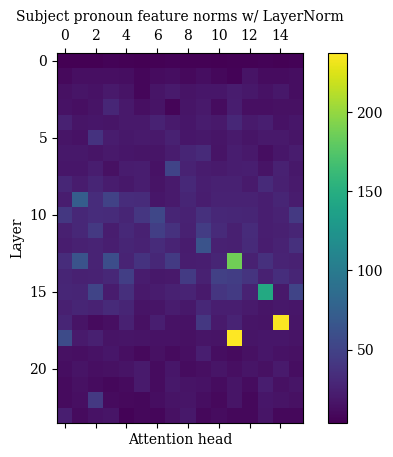

In [118]:
fig, ax = plt.subplots()
subj_feature_sizes_ln_matshow = ax.matshow(subj_feature_sizes_ln)
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
ax.set_title("Subject pronoun feature norms w/ LayerNorm", fontsize=10)
fig.colorbar(subj_feature_sizes_ln_matshow, ax=ax)

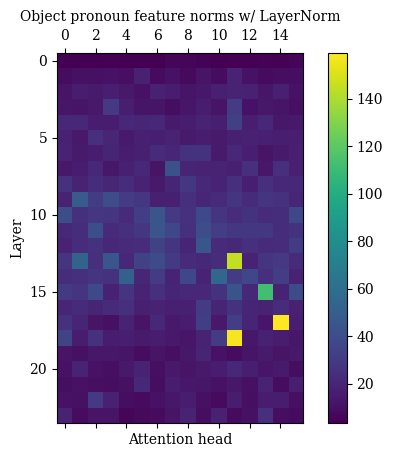

In [95]:
fig, ax = plt.subplots()
obj_feature_sizes_ln_matshow = ax.matshow(obj_feature_sizes_ln)
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
ax.set_title("Object pronoun feature norms w/ LayerNorm", fontsize=10)
fig.colorbar(obj_feature_sizes_ln_matshow, ax=ax)

In [212]:
model.transformer.h[17].ln_1.weight * np.sqrt(2048)

tensor([26.3397, 26.3397, 27.5772,  ..., 26.6933, 24.9255, 27.5772],
       device='cuda:0', grad_fn=<MulBackward0>)

In [76]:
subj_feature_sizes_tensor = torch.from_numpy(np.array(subj_feature_sizes))
top_subj_feature_sizes, top_subj_feature_sizes_indices = torch.topk(subj_feature_sizes_tensor.flatten(), 5)
print("Top heads:")
print(np.array(np.unravel_index(top_subj_feature_sizes_indices.numpy(), subj_feature_sizes_tensor.shape)).T)
print()
print("Top heads' respective values:")
print(top_subj_feature_sizes)

Top heads:
[[18 11]
 [17 14]
 [13 11]
 [15 13]
 [18  0]]

Top heads' respective values:
tensor([72.2168, 70.7219, 45.9200, 39.4049, 17.4824])


In [98]:
subj_feature_sizes_tensor = torch.from_numpy(np.array(subj_feature_sizes_ln))
top_subj_feature_sizes, top_subj_feature_sizes_indices = torch.topk(subj_feature_sizes_tensor.flatten(), 5)
print("Top heads:")
print(np.array(np.unravel_index(top_subj_feature_sizes_indices.numpy(), subj_feature_sizes_tensor.shape)).T)
print()
print("Top heads' respective values:")
print(top_subj_feature_sizes)

Top heads:
[[18 11]
 [17 14]
 [13 11]
 [15 13]
 [ 9  1]]

Top heads' respective values:
tensor([237.3204, 236.2457, 186.3744, 145.4124,  73.2155])


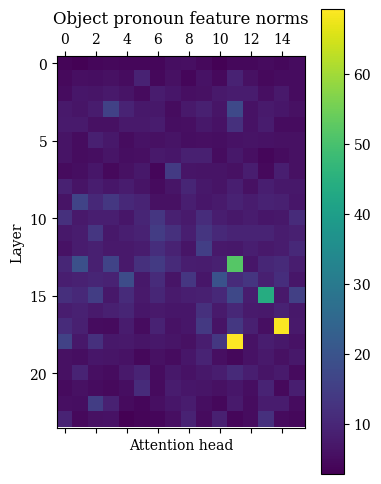

In [128]:
plt.matshow(obj_feature_sizes)
plt.xlabel("Attention head")
plt.ylabel("Layer")
plt.title("Object pronoun feature norms")
plt.colorbar()

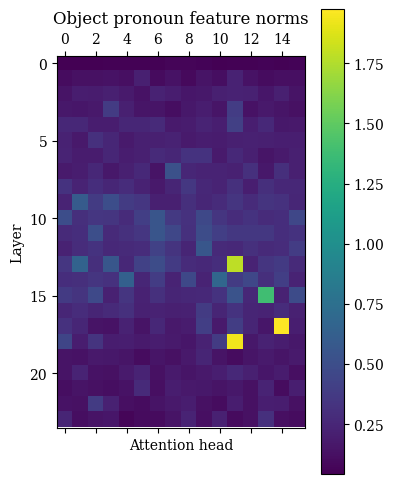

In [87]:
plt.matshow(obj_feature_sizes_ln)
plt.xlabel("Attention head")
plt.ylabel("Layer")
plt.title("Object pronoun feature norms")
plt.colorbar()

In [77]:
obj_feature_sizes_tensor = torch.from_numpy(np.array(obj_feature_sizes))
top_obj_feature_sizes, top_obj_feature_sizes_indices = torch.topk(obj_feature_sizes_tensor.flatten(), 5)
print("Top heads:")
print(np.array(np.unravel_index(top_obj_feature_sizes_indices.numpy(), obj_feature_sizes_tensor.shape)).T)
print()
print("Top heads' respective values:")
print(top_obj_feature_sizes)

Top heads:
[[18 11]
 [17 14]
 [13 11]
 [15 13]
 [14 10]]

Top heads' respective values:
tensor([69.2137, 68.9342, 51.8211, 44.0450, 19.5974])


## Cosine similarities

In [74]:
with torch.no_grad():
    subj_obj_cossims = [ [ cossim(get_attn_normal(model, i, j, subj_range_normal), get_attn_normal(model, i, j, obj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    subj_ctrl_cossims = [ [ cossim(get_attn_normal(model, i, j, subj_range_normal), get_attn_normal(model, i, j, ctrl_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    obj_ctrl_cossims = [ [ cossim(get_attn_normal(model, i, j, obj_range_normal), get_attn_normal(model, i, j, ctrl_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    suffix_subj_cossims = [ [ cossim(get_attn_normal(model, i, j, suffix_range_normal), get_attn_normal(model, i, j, subj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    suffix_obj_cossims = [ [ cossim(get_attn_normal(model, i, j, suffix_range_normal), get_attn_normal(model, i, j, obj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    occupation_subj_cossims = [ [ cossim(get_attn_normal(model, i, j, occupation_range_normal), get_attn_normal(model, i, j, subj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
    occupation_obj_cossims = [ [ cossim(get_attn_normal(model, i, j, occupation_range_normal), get_attn_normal(model, i, j, obj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]

### Subject-object

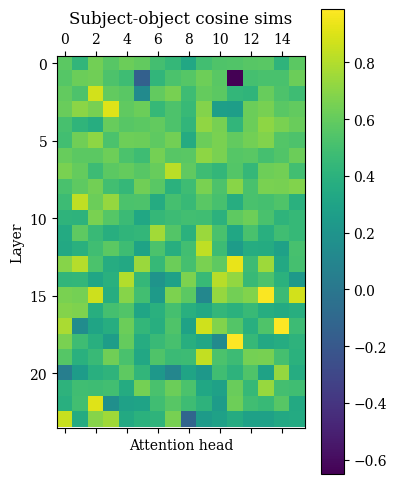

In [72]:
plt.matshow(subj_obj_cossims)
plt.xlabel("Attention head")
plt.ylabel("Layer")
plt.title("Subject-object cosine sims")
plt.colorbar()

Get heads with highest cosine similarities.

In [73]:
subj_obj_cossims_tensor = torch.from_numpy(np.array(subj_obj_cossims))
top_subj_obj_cossims, top_subj_obj_cossim_indices = torch.topk(subj_obj_cossims_tensor.flatten(), 5)
print("Top heads:")
print(np.array(np.unravel_index(top_subj_obj_cossim_indices.numpy(), subj_obj_cossims_tensor.shape)).T)
print()
print("Top heads' respective values:")
print(top_subj_obj_cossims)

Top heads:
[[17 14]
 [18 11]
 [15 13]
 [13 11]
 [22  2]]

Top heads' respective values:
tensor([0.9882, 0.9831, 0.9816, 0.9352, 0.9102])


What's the cosine similarities between our range vectors?

In [74]:
cossim(subj_range_normal, obj_range_normal)

tensor(0.5685, device='cuda:0', grad_fn=<DivBackward0>)

Relatively high, but much lower than those of these attention heads' features. This indicates that these attention heads in particular are performing specific computations relevant to both the subject pronoun case and the object pronoun case. It's not just that the two range normals were similarly-aligned to begin with.

Now, look at cosine similarities with the control range normal.

## Coupling coefficients

In [94]:
subj_obj_couplings = [ [ coupling_coeff(get_attn_normal(model, i, j, subj_range_normal), get_attn_normal(model, i, j, obj_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
subj_ctrl_couplings = [ [ coupling_coeff(get_attn_normal(model, i, j, subj_range_normal), get_attn_normal(model, i, j, ctrl_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
obj_ctrl_couplings = [ [ coupling_coeff(get_attn_normal(model, i, j, obj_range_normal), get_attn_normal(model, i, j, ctrl_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]
subj_occupation_couplings = [ [ coupling_coeff(get_attn_normal(model, i, j, subj_range_normal), get_attn_normal(model, i, j, occupation_range_normal)).detach().cpu().numpy() for j in range(n_heads) ] for i in range(n_layers) ]

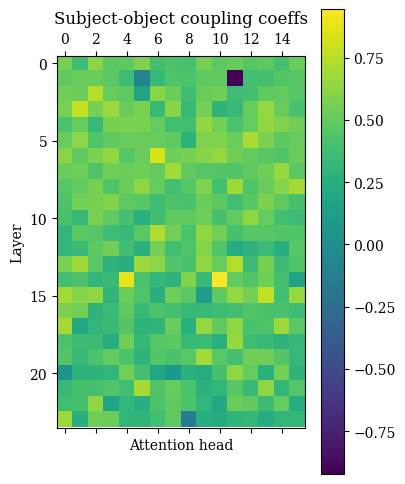

In [78]:
plt.matshow(subj_obj_couplings)
plt.xlabel("Attention head")
plt.ylabel("Layer")
plt.title("Subject-object coupling coeffs")
plt.colorbar()

In [81]:
subj_obj_couplings[17][14], subj_obj_couplings[15][13], subj_obj_couplings[13][11]

(array(0.67086416, dtype=float32),
 array(0.7730598, dtype=float32),
 array(0.73551905, dtype=float32))

# Patching head attribution

In [73]:
def get_layer_head_patching_scores(model, embeddings_pos_np, embeddings_neg_np, range_normal, only_patch_ov=False, no_ln_f=False):
    with torch.no_grad():
        token_idx = -1
        num_layers = len(model.transformer.h)
        num_heads = model.transformer.h[0].attn.attention.num_heads
        out_mat = torch.zeros(num_layers, num_heads).to("cuda")
        embeddings_pos = embeddings_np_to_torch(embeddings_pos_np, free=False)
        if embeddings_neg_np is not None:
            embeddings_neg = embeddings_np_to_torch(embeddings_neg_np, free=False)
        for layer in range(num_layers):
            for head in range(num_heads):    
                if embeddings_neg_np is not None:
                    pos_out, neg_out = path_patching(model, embeddings_pos, embeddings_neg, [(layer, 'attn', head)], only_patch_ov=only_patch_ov, no_ln_f=no_ln_f)
                else:
                    pos_out, neg_out = path_patching(model, embeddings_pos, None, [(layer, 'attn', head)], only_patch_ov=only_patch_ov, no_ln_f=no_ln_f)
                out_mat[layer, head] = (range_normal @ pos_out[0, token_idx]) - (range_normal @ neg_out[0, token_idx]) 
        free_embeddings(embeddings_pos)
        if embeddings_neg_np is not None:
            free_embeddings(embeddings_neg)
    return out_mat

In [74]:
import tqdm
def get_mean_layer_head_patchings_for_embeddings(model, embeddings_pos_list, embeddings_neg_list, range_normal, only_patch_ov=False, no_ln_f=False):
    out_mat = 0
    if embeddings_neg_list is not None:
        for embeddings_pos_np, embeddings_neg_np in tqdm.tqdm(zip(embeddings_pos_list, embeddings_neg_list)):
            out_mat = out_mat + get_layer_head_patching_scores(model, embeddings_pos_np, embeddings_neg_np, range_normal, only_patch_ov=only_patch_ov, no_ln_f=no_ln_f)
    else:
        for embeddings_pos_np in tqdm.tqdm(embeddings_pos_list):
            out_mat = out_mat + get_layer_head_patching_scores(model, embeddings_pos_np, None, range_normal, only_patch_ov=only_patch_ov, no_ln_f=no_ln_f)
    out_mat /= len(embeddings_pos_list)
    return out_mat

In [88]:
import tqdm
def get_mean_layer_head_patchings_for_prompts(model, prompts_pos, prompts_neg, range_normal, only_patch_ov=False, no_ln_f=False, use_tqdm=True, pre_tokenized=False):
    out_mat = 0
    with torch.no_grad():
        if use_tqdm: tqdm_lambda = lambda x: tqdm.tqdm(x)
        else: tqdm_lambda = lambda x: x
        for i, tuple in tqdm_lambda(enumerate(zip(prompts_pos, prompts_neg))):
            prompt_pos, prompt_neg = tuple
            embedding_pos, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt_pos['input_ids'].to("cuda:0"), 'attention_mask': prompt_pos['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt_pos, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            embedding_pos = embeddings_torch_to_np(embedding_pos)

            embedding_neg, hooks = attach_hooks(model)
            if pre_tokenized:
                tokens = {"input_ids": prompt_neg['input_ids'].to("cuda:0"), 'attention_mask': prompt_neg['attention_mask'].to("cuda:0")}
            else:
                tokens = tokenizer(prompt_neg, return_tensors="pt").to("cuda:0")
            model(**tokens)
            for hook in hooks: hook.remove()
            embedding_neg = embeddings_torch_to_np(embedding_neg)
            
            out_mat = out_mat + get_layer_head_patching_scores(model, embedding_pos, embedding_neg, range_normal, only_patch_ov=only_patch_ov, no_ln_f=no_ln_f)
            
            free_embeddings(embedding_pos)
            free_embeddings(embedding_neg)
            do_free()
        out_mat /= len(prompts_pos)
    return out_mat

In [75]:
def get_top_for_matrix(matrix, largest=True, k=5):
    obj_feature_sizes_tensor = torch.from_numpy(np.array(matrix))
    top_obj_feature_sizes, top_obj_feature_sizes_indices = torch.topk(obj_feature_sizes_tensor.flatten(), k, largest=largest)
    print("Top heads:")
    print(np.array(np.unravel_index(top_obj_feature_sizes_indices.numpy(), obj_feature_sizes_tensor.shape)).T)
    print()
    print("Top heads' respective values:")
    print(top_obj_feature_sizes)

## Subject pronouns

In [76]:
subj_lm_normal = make_lm_head_normal([' she'], [' he']).to("cuda")

In [92]:
subj_head_patchings = get_mean_layer_head_patchings_for_prompts(model, subj_prompts_female, subj_prompts_male, subj_lm_normal)

300it [14:51,  2.97s/it]


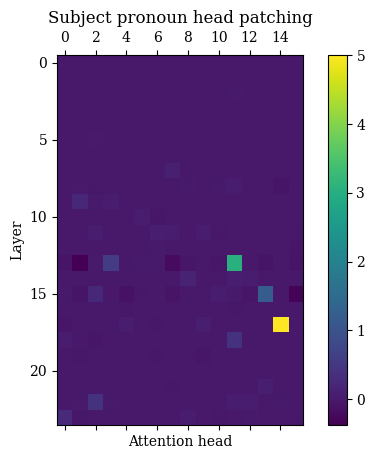

In [93]:
fig, ax = plt.subplots()
ax.set_title("Subject pronoun head patching")
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
matshow = ax.matshow(subj_head_patchings.detach().cpu().numpy())
fig.colorbar(matshow, ax=ax)
plt.show()

In [94]:
get_top_for_matrix(subj_head_patchings.detach().cpu())

Top heads:
[[17 14]
 [13 11]
 [15 13]
 [13  3]
 [22  2]]

Top heads' respective values:
tensor([5.0037, 3.0501, 1.1985, 0.5844, 0.4263])


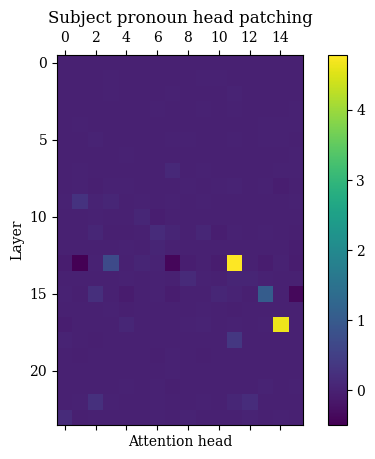

In [78]:
fig, ax = plt.subplots()
ax.set_title("Subject pronoun head patching")
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
matshow = ax.matshow(subj_head_patchings.detach().cpu().numpy())
fig.colorbar(matshow, ax=ax)
plt.show()

In [124]:
get_top_for_matrix(subj_head_patchings.detach().cpu())

Top heads:
[[17 14]
 [13 11]
 [15 13]
 [13  3]
 [18 11]]

Top heads' respective values:
tensor([4.7859, 4.5473, 1.0804, 0.6352, 0.4049])


## Obj pronouns

In [95]:
obj_lm_normal = make_lm_head_normal([' her'], [' him']).to("cuda")

In [96]:
obj_head_patchings = get_mean_layer_head_patchings_for_prompts(model, obj_prompts_female, obj_prompts_male, obj_lm_normal)

300it [14:57,  2.99s/it]


In [105]:
obj_head_patchings = get_mean_layer_head_patchings_for_embeddings(model, obj_embeddings_female, obj_embeddings_male, obj_lm_normal)

10it [00:15,  1.52s/it]


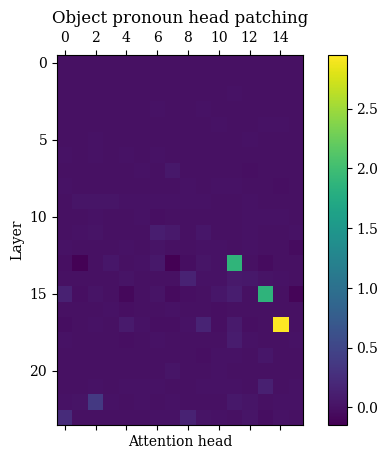

In [97]:
fig, ax = plt.subplots()
ax.set_title("Object pronoun head patching")
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
matshow = ax.matshow(obj_head_patchings.detach().cpu().numpy())
fig.colorbar(matshow, ax=ax)
plt.show()

In [98]:
get_top_for_matrix(obj_head_patchings.detach().cpu())

Top heads:
[[17 14]
 [13 11]
 [15 13]
 [22  2]
 [23  0]]

Top heads' respective values:
tensor([2.9491, 1.8853, 1.8634, 0.3653, 0.2359])


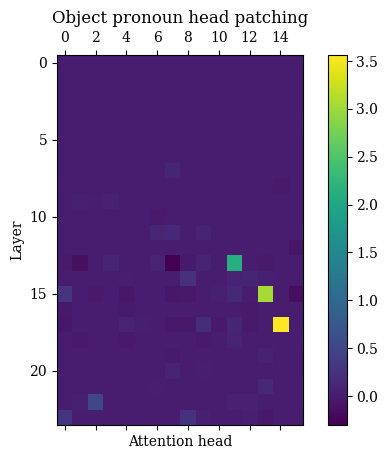

In [113]:
fig, ax = plt.subplots()
ax.set_title("Object pronoun head patching")
ax.set_xlabel("Attention head")
ax.set_ylabel("Layer")
matshow = ax.matshow(obj_head_patchings.detach().cpu().numpy())
fig.colorbar(matshow, ax=ax)
plt.show()

In [116]:
get_top_for_matrix(obj_head_patchings.detach().cpu())

Top heads:
[[17 14]
 [15 13]
 [13 11]
 [22  2]
 [15  0]]

Top heads' respective values:
tensor([3.5636, 3.0652, 2.1328, 0.5218, 0.2863])


# Finding feature vectors

## Preparation

In [64]:
cur_occu_embeddings_female = embeddings_np_to_torch(occu_embeddings_female[0], free=False)
cur_occu_embeddings_male = embeddings_np_to_torch(occu_embeddings_male[0], free=False)

In [65]:
cur_subj_embeddings_female = embeddings_np_to_torch(subj_embeddings_female[0], free=False)
cur_subj_embeddings_male = embeddings_np_to_torch(subj_embeddings_male[0], free=False)

In [66]:
cur_obj_embeddings_female = embeddings_np_to_torch(obj_embeddings_female[0], free=False)
cur_obj_embeddings_male = embeddings_np_to_torch(obj_embeddings_male[0], free=False)

## Path patching recursion

### Subject pronouns

In [122]:
_ = patch_get_max_paths(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal, 4, 10)

Paths of length 1:
attn13.11@5: 3.4273200035095215
mlp18@-1: 2.334465503692627
attn17.14@4: 1.6758766174316406
mlp16@-1: 1.5480985641479492
mlp19@-1: 1.0288758277893066
attn17.14@9: 0.8834829330444336
attn17.14@10: 0.829963207244873
mlp17@-1: 0.6939783096313477
attn13.11@4: 0.6556925773620605
attn17.14@5: 0.6509819030761719
embedding@-1: -4.76837158203125e-07

Paths of length 2:
attn13.11@5 <= attn9.1@3: 1.336902141571045
attn13.11@5 <= attn6.6@3: 0.809196949005127
attn17.14@4 <= attn13.3@3: 0.4383583068847656
mlp16@-1 <= attn13.3@3: 0.375551700592041
attn17.14@4 <= attn9.1@3: 0.3448495864868164
mlp17@-1 <= attn13.11@5: 0.3383798599243164
attn13.11@4 <= attn9.1@3: 0.3243856430053711
attn17.14@10 <= attn9.1@3: 0.3155651092529297
attn13.11@5 <= attn10.5@5: 0.307647705078125
attn17.14@4 <= attn15.13@3: 0.25746870040893555
attn13.11@5 <= embedding@5: 0.0
attn17.14@4 <= embedding@4: 0.0
mlp16@-1 <= embedding@-1: 0.0
mlp19@-1 <= embedding@-1: 0.0
attn17.14@9 <= embedding@9: 0.0
attn17.14@10 

### Object pronouns

In [75]:
_ = patch_get_max_paths(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal, 3, 10)

Paths of length 1:
mlp18@-1: 3.437502145767212
attn15.13@6: 2.464179039001465
attn17.14@7: 1.8911547660827637
attn13.11@6: 1.5276784896850586
attn13.11@7: 0.9481534957885742
attn17.14@11: 0.8216190338134766
attn17.14@9: 0.7756085395812988
attn17.14@8: 0.5406274795532227
attn18.11@6: 0.5189943313598633
attn23.8@11: 0.3799419403076172
embedding@-1: 0.0

Paths of length 2:
attn15.13@6 <= mlp12@6: 0.9650425910949707
mlp18@-1 <= attn15.13@6: 0.4858846664428711
attn13.11@6 <= attn6.6@6: 0.39538097381591797
attn17.14@7 <= attn13.3@6: 0.39145851135253906
attn17.14@7 <= attn15.13@6: 0.36108875274658203
attn17.14@11 <= attn15.13@6: 0.3336629867553711
attn17.14@7 <= mlp12@7: 0.32725000381469727
attn17.14@7 <= attn13.11@7: 0.3150959014892578
attn15.13@6 <= mlp0@6: 0.3031148910522461
attn15.13@6 <= attn6.6@6: 0.2721385955810547
attn15.13@6 <= embedding@6: 0.002132415771484375
attn18.11@6 <= embedding@6: 0.00024175643920898438
embedding@-1: 0.0
mlp18@-1 <= embedding@-1: 0.0
attn17.14@7 <= embedding@

### Occupations

In [120]:
_ = patch_get_max_paths(model, cur_embeddings_female, cur_embeddings_male, better_diff_ln_f_normal, 4, 10)

Paths of length 1:
mlp18@-1: 0.8984694480895996
mlp22@-1: 0.5668761730194092
mlp16@-1: 0.5379655361175537
attn23.8@6: 0.3917241096496582
mlp21@-1: 0.3572816848754883
attn23.1@6: 0.3237144947052002
mlp20@-1: 0.30431365966796875
attn21.13@5: 0.2827794551849365
mlp19@-1: 0.2637805938720703
attn15.13@3: 0.21320676803588867
embedding@-1: 0.0

Paths of length 2:
mlp18@-1 <= mlp16@-1: 0.22571659088134766
mlp22@-1 <= mlp20@-1: 0.16983246803283691
mlp21@-1 <= mlp18@-1: 0.15436887741088867
mlp19@-1 <= mlp16@-1: 0.14850091934204102
mlp16@-1 <= attn15.13@3: 0.13726472854614258
mlp20@-1 <= mlp15@-1: 0.13591718673706055
mlp21@-1 <= mlp16@-1: 0.1356348991394043
mlp16@-1 <= attn13.3@3: 0.13139772415161133
mlp18@-1 <= attn15.13@3: 0.11214351654052734
mlp16@-1 <= attn9.1@3: 0.10793447494506836
mlp18@-1 <= embedding@-1: 9.5367431640625e-07
mlp21@-1 <= embedding@-1: 9.5367431640625e-07
mlp22@-1 <= embedding@-1: 4.76837158203125e-07
attn23.8@6 <= embedding@6: 4.76837158203125e-07
attn23.1@6 <= embedding@6:

In [164]:
_ = patch_get_max_paths(model, cur_embeddings_female, cur_embeddings_male, better_diff_ln_f_normal, 7, 15)

Paths of length 1:
mlp18@-1: 0.8984694480895996
mlp22@-1: 0.5668761730194092
mlp16@-1: 0.5379655361175537
attn23.8@6: 0.3917241096496582
mlp21@-1: 0.3572816848754883
attn23.1@6: 0.3237144947052002
mlp20@-1: 0.30431365966796875
attn21.13@5: 0.2827794551849365
mlp19@-1: 0.2637805938720703
attn15.13@3: 0.21320676803588867
attn23.12@6: 0.17145609855651855
attn23.9@6: 0.1677227020263672
attn23.13@6: 0.14931273460388184
attn13.10@4: 0.11520195007324219
attn23.0@6: 0.10534524917602539
embedding@-1: 0.0

Paths of length 2:
mlp18@-1 <= mlp16@-1: 0.22571659088134766
mlp22@-1 <= mlp20@-1: 0.16983246803283691
mlp21@-1 <= mlp18@-1: 0.15436887741088867
mlp19@-1 <= mlp16@-1: 0.14850091934204102
mlp16@-1 <= attn15.13@3: 0.13726472854614258
mlp20@-1 <= mlp15@-1: 0.13591718673706055
mlp21@-1 <= mlp16@-1: 0.1356348991394043
mlp16@-1 <= attn13.3@3: 0.13139772415161133
mlp18@-1 <= attn15.13@3: 0.11214351654052734
mlp16@-1 <= attn9.1@3: 0.10793447494506836
mlp20@-1 <= mlp17@-1: 0.10595941543579102
mlp16@-1 

Let's see if different paths converge to the same feature vectors.

In [75]:
occu_normal_path_1 = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ]
)

occu_normal_path_2 = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 22, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 20, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ]
)

occu_normal_path_3 = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 21, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 18, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ]
)

cossim(occu_normal_path_1, occu_normal_path_2),\
    cossim(occu_normal_path_2, occu_normal_path_3),\
    cossim(occu_normal_path_1, occu_normal_path_3)

(tensor(0.9602, device='cuda:0'),
 tensor(0.9781, device='cuda:0'),
 tensor(0.9756, device='cuda:0'))

This motivates a good choice of starting path.

In [127]:
_ = patch_get_max_paths(model, cur_embeddings_female, cur_embeddings_male, better_diff_ln_f_normal, 3, 10,
    starting_path=list(reversed([
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ]))
)

Paths of length 1:
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= mlp1@3: 0.0009961128234863281
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= mlp0@3: 0.0009665489196777344
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= mlp2@3: 0.00011682510375976562
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.14@3: 0.00010156631469726562
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.11@3: 4.9114227294921875e-05
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.6@3: 4.57763671875e-05
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.3@3: 3.814697265625e-05
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.8@3: 3.7670135498046875e-05
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3 <= attn6.6@3 <= attn0.9@3: 3.7670135498046875e-05
mlp19@-1 

In [140]:
_ = patch_get_max_paths(model, cur_embeddings_female, cur_embeddings_male, better_diff_ln_f_normal, 3, 10,
    starting_path=list(reversed([
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1}
    ]))
)

Paths of length 1:
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn6.6@3: 0.011085033416748047
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn9.1@3: 0.008693218231201172
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= mlp1@3: 0.00819540023803711
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= mlp8@3: 0.005135536193847656
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= mlp0@3: 0.004185676574707031
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn0.9@3: 0.0016169548034667969
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= mlp10@3: 0.0014848709106445312
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn8.14@3: 0.0014500617980957031
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn0.14@3: 0.0014009475708007812
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= mlp6@3: 0.0013060569763183594
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= embedding@3: -0.00014925003051757812

Paths of length 2:
mlp19@-1 <= mlp16@-1 <= attn15.13@3 <= mlp12@3 <= attn6.6@3 <=

In [93]:
_ = patch_get_max_paths(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal, 5, 20)

Paths of length 1:
attn13.11@5: 3.427302122116089
mlp18@-1: 2.334465980529785
attn17.14@4: 1.6759061813354492
mlp16@-1: 1.548098087310791
mlp19@-1: 1.0288801193237305
attn17.14@9: 0.8834958076477051
attn17.14@10: 0.8299517631530762
mlp17@-1: 0.6939740180969238
attn13.11@4: 0.6556978225708008
attn17.14@5: 0.6509799957275391
attn15.13@5: 0.5109343528747559
mlp15@-1: 0.3280806541442871
attn15.13@3: 0.28732824325561523
attn18.11@8: 0.27251768112182617
attn17.14@8: 0.26997947692871094
attn13.3@3: 0.26619482040405273
attn17.14@3: 0.2450103759765625
attn23.0@11: 0.22838592529296875
attn15.13@4: 0.20160531997680664
attn13.11@6: 0.19784832000732422
embedding@-1: 0.0

Paths of length 2:
attn13.11@5 <= attn9.1@3: 1.33689546585083
attn13.11@5 <= attn6.6@3: 0.8091940879821777
attn17.14@4 <= attn13.3@3: 0.4383659362792969
mlp16@-1 <= attn13.3@3: 0.3755531311035156
attn17.14@4 <= attn9.1@3: 0.34485578536987305
mlp17@-1 <= attn13.11@5: 0.3383779525756836
attn13.11@4 <= attn9.1@3: 0.3243894577026367
at

## Finding feature vectors

In [74]:
occu_mlp1_normal = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
        {'layer': 1, 'sublayer': 'mlp', 'token': 3, 'head': -1}
    ], use_ln=False, normalize=True
)

occu_mlp1_attn0_normal = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
        {'layer': 1, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 0, 'sublayer': 'attn', 'token': 3, 'head': -1},
    ], use_ln=False, normalize=True
)

occu_attn6_normal = get_normal_for_path(model, cur_occu_embeddings_female, cur_occu_embeddings_male, occu_ln_f_normal,
    [
        {'layer': 19, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 16, 'sublayer': 'mlp', 'token': -1, 'head': -1},
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
        {'layer': 12, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ], use_ln=False, normalize=True
)

In [75]:
subj_mlp1_normal = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
        {'layer': 1, 'sublayer': 'mlp', 'token': 3, 'head': -1}
    ], use_ln=False, normalize=True
)

subj_mlp1_attn0_normal = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
        {'layer': 1, 'sublayer': 'mlp', 'token': 3, 'head': -1},
        {'layer': 0, 'sublayer': 'attn', 'token': 3, 'head': -1}
    ], use_ln=False, normalize=True
)

subj_attn6_normal = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ], use_ln=False, normalize=True
)

In [83]:
subj_attn6_normal_with_mag = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
        {'layer': 9, 'sublayer': 'attn', 'token': 3, 'head': 1},
        {'layer': 6, 'sublayer': 'attn', 'token': 3, 'head': 6},
    ], use_ln=True
)

obj_attn6_normal_with_mag = get_normal_for_path(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 6, 'head': 11},
        {'layer': 6, 'sublayer': 'attn', 'token': 6, 'head': 6},
    ], use_ln=True,
)

In [85]:
cossim(subj_attn6_normal_with_mag, obj_attn6_normal_with_mag).item()

0.9520992040634155

In [114]:
cossim(subj_mlp1_normal, occu_mlp1_normal),\
cossim(subj_mlp1_attn0_normal, occu_mlp1_attn0_normal),\
cossim(subj_attn6_normal, occu_attn6_normal)

(tensor(0.9771, device='cuda:0'),
 tensor(0.9750, device='cuda:0'),
 tensor(0.9663, device='cuda:0'))

# Get observable scores and feature scores

## Occupations

In [79]:
occu_observable = make_lm_head_normal([' nurse', ' teacher', ' secretary'], [' programmer', ' doctor', ' engineer'])

In [72]:
occu_scores_male = get_normal_list_scores_for_prompt_list(model,[
    {'normal': occu_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'occu_mlp1_normal'},
    {'normal': occu_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': 3, 'name': 'occu_attn6_normal'},
    {'normal': occu_observable.detach().cpu().numpy(), 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'occu_observable'},
], occu_prompts_male)

occu_scores_female = get_normal_list_scores_for_prompt_list(model,[
    {'normal': occu_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'occu_mlp1_normal'},
    {'normal': occu_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': 3, 'name': 'occu_attn6_normal'},
    {'normal': occu_observable.detach().cpu().numpy(), 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'occu_observable'},
], occu_prompts_female)

300it [03:54,  1.28it/s]
300it [03:54,  1.28it/s]


## Pronouns

In [78]:
subj_observable = make_lm_head_normal([' she'], [' he'])

In [74]:
subj_scores_male = get_normal_list_scores_for_prompt_list(model,[
    {'normal': subj_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'subj_mlp1_normal'},
    {'normal': subj_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': 3, 'name': 'subj_attn6_normal'},
    {'normal': subj_observable.detach().cpu().numpy(), 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'subj_observable'},
], subj_prompts_male)

subj_scores_female = get_normal_list_scores_for_prompt_list(model,[
    {'normal': subj_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': 3, 'name': 'subj_mlp1_normal'},
    {'normal': subj_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': 3, 'name': 'subj_attn6_normal'},
    {'normal': subj_observable.detach().cpu().numpy(), 'layer': None, 'sublayer': 'lm_out', 'token': -1, 'name': 'subj_observable'},
], subj_prompts_female)

300it [03:55,  1.28it/s]
300it [03:55,  1.28it/s]


## Evaluation

In [75]:
import pickle
pickle.dump({
    'occu_scores_male': occu_scores_male,
    'occu_scores_female': occu_scores_female,
    'subj_scores_male': subj_scores_male,
    'subj_scores_female': subj_scores_female,
}, open("normal_scores_new.pkl", "wb"))

In [99]:
import pickle
my_scores = pickle.load(open("normal_scores_new.pkl", "rb"))
occu_scores_male = my_scores['occu_scores_male']
occu_scores_female = my_scores['occu_scores_female']
subj_scores_male = my_scores['subj_scores_male']
subj_scores_female = my_scores['subj_scores_female']

In [100]:
import matplotlib.pyplot as plt
import numpy as np

In [101]:
xs = occu_scores_male[1]['scores'] + occu_scores_female[1]['scores']
ys = occu_scores_male[2]['scores'] + occu_scores_female[2]['scores']

fit, fit_info = np.polynomial.Polynomial.fit(xs, ys, 1, full=True)
fit = fit.convert()
r2 = 1 - fit_info[0] / (len(ys) * np.array(ys).var())
fit, r2

(Polynomial([0.01955477, 0.50863145], domain=[-1.,  1.], window=[-1.,  1.], symbol='x'),
 array([0.8816692], dtype=float32))

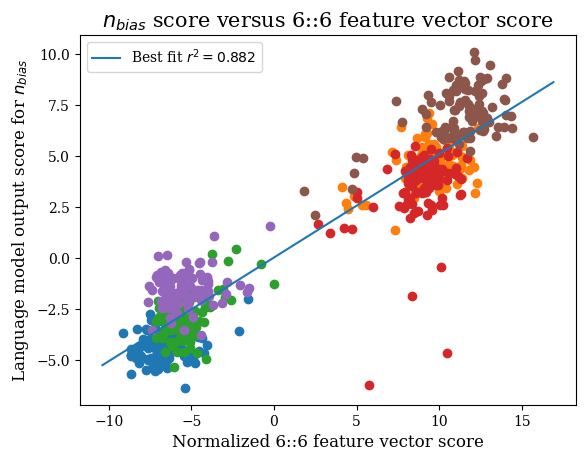

In [105]:
xs = occu_scores_male[1]['scores'] + occu_scores_female[1]['scores']
ys = occu_scores_male[2]['scores'] + occu_scores_female[2]['scores']

fit, fit_info = np.polynomial.Polynomial.fit(xs, ys, 1, full=True)
fit = fit.convert()
r2 = 1 - fit_info[0] / (len(ys) * np.array(ys).var())
fit, r2

fig, ax = plt.subplots()

ax.scatter(occu_scores_male[1]['scores'][:100], occu_scores_male[-1]['scores'][:100])
ax.scatter(occu_scores_female[1]['scores'][:100], occu_scores_female[-1]['scores'][:100])

ax.scatter(occu_scores_male[1]['scores'][100:200], occu_scores_male[-1]['scores'][100:200])
ax.scatter(occu_scores_female[1]['scores'][100:200], occu_scores_female[-1]['scores'][100:200])

ax.scatter(occu_scores_male[1]['scores'][200:300], occu_scores_male[-1]['scores'][200:300])
ax.scatter(occu_scores_female[1]['scores'][200:300], occu_scores_female[-1]['scores'][200:300])


xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], fit.coef[0] + np.array([xmin, xmax])*fit.coef[1], label=f'Best fit $r^2 = {r2[0]:.3f}$')
plt.xlabel("Normalized 6::6 feature vector score", fontsize=12)
plt.ylabel("Language model output score for $n_{bias}$", fontsize=12)
plt.title("$n_{bias}$ score versus 6::6 feature vector score", fontsize=15)
plt.legend()

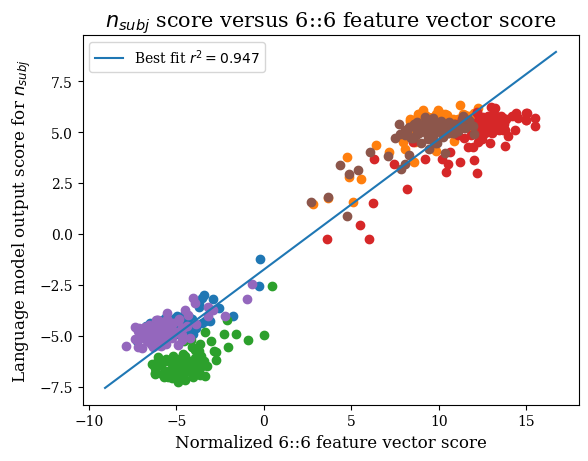

In [106]:
xs = subj_scores_male[1]['scores'] + subj_scores_female[1]['scores']
ys = subj_scores_male[-1]['scores'] + subj_scores_female[-1]['scores']

fit, fit_info = np.polynomial.Polynomial.fit(xs, ys, 1, full=True)
fit = fit.convert()
r2 = 1 - fit_info[0] / (len(ys) * np.array(ys).var())
fit, r2

fig, ax = plt.subplots()

ax.scatter(subj_scores_male[1]['scores'][:100], subj_scores_male[-1]['scores'][:100])
ax.scatter(subj_scores_female[1]['scores'][:100], subj_scores_female[-1]['scores'][:100])

ax.scatter(subj_scores_male[1]['scores'][100:200], subj_scores_male[-1]['scores'][100:200])
ax.scatter(subj_scores_female[1]['scores'][100:200], subj_scores_female[-1]['scores'][100:200])

ax.scatter(subj_scores_male[1]['scores'][200:300], subj_scores_male[-1]['scores'][200:300])
ax.scatter(subj_scores_female[1]['scores'][200:300], subj_scores_female[-1]['scores'][200:300])


xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], fit.coef[0] + np.array([xmin, xmax])*fit.coef[1], label=f'Best fit $r^2 = {r2[0]:.3f}$')
plt.xlabel("Normalized 6::6 feature vector score", fontsize=12)
plt.ylabel("Language model output score for $n_{subj}$", fontsize=12)
plt.title("$n_{subj}$ score versus 6::6 feature vector score", fontsize=15)
plt.legend()

# Top activating examples

In [106]:
def decode_prompt_and_tokens(prompts, prompt, mid_token, window_size=5):
    print(tokenizer.batch_decode(prompts[prompt]['input_ids'][:,max(0,mid_token-window_size):mid_token+window_size]))
    print(tokenizer.batch_decode(prompts[prompt]['input_ids'][:,mid_token]))

## Get scores on pile-10k

In [47]:
from datasets import load_dataset
pile10k = load_dataset("NeelNanda/pile-10k")

Found cached dataset parquet (/home/jhd43/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
tokenized_prompts = []
for prompt in pile10k['train']['text']:
    tokenized_prompts.append(tokenizer(prompt, return_tensors="pt"))
tokenized_prompts = slice_tokenized_prompts_into_context_windows(tokenized_prompts, 128, max_tokens=1000000)

Token indices sequence length is longer than the specified maximum sequence length for this model (3180 > 2048). Running this sequence through the model will result in indexing errors


In [90]:
len(tokenized_prompts)

7860

In [49]:
get_num_tensors()
do_free()
get_num_tensors()

/gpfs/gibbs/project/cohan/jhd43/conda_envs/nlp_env/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:293: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


0

In [78]:
subj_attn17_normal_with_mag = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 3, 'head': 14},
    ], use_ln=True
)
obj_attn17_normal_with_mag = get_normal_for_path(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal,
    [
        {'layer': 17, 'sublayer': 'attn', 'token': 6, 'head': 14},
    ], use_ln=True
)

subj_attn15_normal_with_mag = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 3, 'head': 13},
    ], use_ln=True
)
obj_attn15_normal_with_mag = get_normal_for_path(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal,
    [
        {'layer': 15, 'sublayer': 'attn', 'token': 6, 'head': 13},
    ], use_ln=True
)

subj_attn13_normal_with_mag = get_normal_for_path(model, cur_subj_embeddings_female, cur_subj_embeddings_male, subj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 3, 'head': 11},
    ], use_ln=True
)
obj_attn13_normal_with_mag = get_normal_for_path(model, cur_obj_embeddings_female, cur_obj_embeddings_male, obj_ln_f_normal,
    [
        {'layer': 13, 'sublayer': 'attn', 'token': 6, 'head': 11},
    ], use_ln=True
)

In [81]:
coupling_coeff(subj_attn17_normal_with_mag, obj_attn17_normal_with_mag).item(),\
coupling_coeff(subj_attn15_normal_with_mag, obj_attn15_normal_with_mag).item(),\
coupling_coeff(subj_attn13_normal_with_mag, obj_attn13_normal_with_mag).item()

(0.7122678160667419, 0.8010773062705994, 0.7477921843528748)

In [82]:
cossim(subj_attn17_normal_with_mag, obj_attn17_normal_with_mag).item(),\
cossim(subj_attn15_normal_with_mag, obj_attn15_normal_with_mag).item(),\
cossim(subj_attn13_normal_with_mag, obj_attn13_normal_with_mag).item()

(0.988246738910675, 0.981793224811554, 0.9359292387962341)

In [117]:
pile_scores = get_normal_list_scores_for_prompt_list(model,[
    {'normal': occu_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': None, 'name': 'occu_mlp1_normal'},
    {'normal': occu_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'occu_attn6_normal'},
    {'normal': subj_mlp1_normal.detach().cpu().numpy(), 'layer': 1, 'sublayer': 'ln_2_in', 'token': None, 'name': 'subj_mlp1_normal'},
    {'normal': subj_attn6_normal.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'subj_attn6_normal'},
    {'normal': obj_attn6_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obj_attn6_normal_with_mag'},
    {'normal': subj_attn17_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'subj_attn17_normal_with_mag'},
    {'normal': obj_attn17_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obj_attn17_normal_with_mag'},
    {'normal': subj_attn15_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'subj_attn15_normal_with_mag'},
    {'normal': obj_attn15_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obj_attn15_normal_with_mag'},
    {'normal': subj_attn13_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'subj_attn13_normal_with_mag'},
    {'normal': obj_attn13_normal_with_mag.detach().cpu().numpy(), 'layer': 6, 'sublayer': 'ln_1_in', 'token': None, 'name': 'obj_attn13_normal_with_mag'},
], tokenized_prompts, pre_tokenized=True, save_every=10, save_out="scores_on_pile.pkl")

7860it [3:07:12,  1.43s/it]


In [118]:
pickle.dump(pile_scores, open("pile_scores_full.pkl", "wb"))

## `occu_mlp1_normal`

In [78]:
occu_mlp1_top_scores = get_top_normal_scores_for_prompt_list(model, 1, 'ln_2_in', tokenized_prompts, occu_mlp1_normal, k=20, pre_tokenized=True)

100%|██████████| 298/298 [03:25<00:00,  1.45it/s]


In [79]:
for entry in occu_mlp1_top_scores:
    decode_prompt_and_tokens(tokenized_prompts, entry['prompt_idx'], entry['token_idx'], window_size=18)
    print(f"Score: {entry['score']}")
    print()

[' across the globe with WebEx Meetings. In this course, author and webinar specialist Sally Norred shows you how to use WebEx Meetings to host, run, and']
[' Sally']
Score: 12.807328224182129

["\nHello! It's nice to meet you! I'm Mary. Thank you for stopping by Stirring Up Delight. I hope you'll find"]
[' Mary']
Score: 12.135202407836914

[' phosphate (Pi) uptake across the vacuolar membrane of intact vacuoles isolated from Catharanthus roseus suspension-cultured cells was measured. Under low Pi status,']
[' Cath']
Score: 12.103666305541992

['Inorganic phosphate uptake in intact vacuoles isolated from suspension-cultured cells of Catharanthus roseus (L.) G. Don under varying Pi status.\nIn']
[' Cath']
Score: 11.904487609863281

[' theme. But how to make it work? Are you the borg, or fighting the Borg?\n\nThe third and final idea came to me through my girlfriend']
[' Borg']
Score: 11.679457664489746

[' especially when the food is good. Good food tastes even better when enjoyed with 

## `occu_attn6_normal`

In [80]:
occu_attn6_top_scores = get_top_normal_scores_for_prompt_list(model, 6, 'ln_1_in', tokenized_prompts, occu_attn6_normal, k=20, pre_tokenized=True)

100%|██████████| 298/298 [03:26<00:00,  1.45it/s]


In [81]:
for entry in occu_attn6_top_scores:
    decode_prompt_and_tokens(tokenized_prompts, entry['prompt_idx'], entry['token_idx'], window_size=18)
    print(f"Score: {entry['score']}")
    print()

[' add 4,000 square feet to its current space. View Full Caption DNAinfo/Katie Honan\n\nJACKSON HEIGHTS — Indian grocery store Patel Brothers is planning']
['ie']
Score: 11.403040885925293

['.\n\nAn individual may bring a private right of action in federal court against his/her employer for such retaliation. In addition, the SEC may bring an enforcement action against a']
['her']
Score: 11.098417282104492

['Jeanette Sawyer Cohen, PhD, clinical assistant professor of psychology in pediatrics at Weill Cornell']
['ette']
Score: 10.28715705871582

['changing” economics, no matter how combatively BJP chief Amit Shah defended it in his maiden speech in the Rajya Sabha.\n\nYoung Indians of any class, on whose']
[' maiden']
Score: 10.135647773742676

['�vásárhely – Doubles\n\nLaura Pigossi and Nadia Podoroska were the defending champions, but both players chose not to participate.\n']
['ia']
Score: 10.087481498718262

[' Hódmezővásárhely – Doubles\n\nLaura Pigossi and Nadia Podoroska were th

## `subj_mlp1_normal`

In [104]:
subj_mlp1_top_scores = get_top_normal_scores_for_prompt_list(model, 1, 'ln_2_in', tokenized_prompts[:298], subj_mlp1_normal, k=20, pre_tokenized=True)

100%|██████████| 298/298 [03:07<00:00,  1.59it/s]


In [107]:
for entry in subj_mlp1_top_scores:
    decode_prompt_and_tokens(tokenized_prompts[:298], entry['prompt_idx'], entry['token_idx'], window_size=18)
    print(f"Score: {entry['score']}")
    print()

[' across the globe with WebEx Meetings. In this course, author and webinar specialist Sally Norred shows you how to use WebEx Meetings to host, run, and']
[' Sally']
Score: 11.065218925476074

["\nHello! It's nice to meet you! I'm Mary. Thank you for stopping by Stirring Up Delight. I hope you'll find"]
[' Mary']
Score: 10.82946491241455

[' phosphate (Pi) uptake across the vacuolar membrane of intact vacuoles isolated from Catharanthus roseus suspension-cultured cells was measured. Under low Pi status,']
[' Cath']
Score: 10.75033950805664

[' theme. But how to make it work? Are you the borg, or fighting the Borg?\n\nThe third and final idea came to me through my girlfriend']
[' Borg']
Score: 10.398216247558594

[' especially when the food is good. Good food tastes even better when enjoyed with people. Tonight Amy came over to try my second attempt at the Brussels Sprouts Veggie Soup to which']
[' Amy']
Score: 10.381427764892578

['Inorganic phosphate uptake in intact vacuoles isolate

## `subj_attn6_normal`

In [108]:
subj_attn6_top_scores = get_top_normal_scores_for_prompt_list(model, 6, 'ln_1_in', tokenized_prompts[:298], subj_attn6_normal, k=20, pre_tokenized=True)

100%|██████████| 298/298 [03:08<00:00,  1.58it/s]


In [109]:
for entry in subj_attn6_top_scores:
    decode_prompt_and_tokens(tokenized_prompts[:298], entry['prompt_idx'], entry['token_idx'], window_size=18)
    print(f"Score: {entry['score']}")
    print()

['.\n\nAn individual may bring a private right of action in federal court against his/her employer for such retaliation. In addition, the SEC may bring an enforcement action against a']
['her']
Score: 11.647647857666016

['Jeanette Sawyer Cohen, PhD, clinical assistant professor of psychology in pediatrics at Weill Cornell']
['ette']
Score: 11.624452590942383

[' add 4,000 square feet to its current space. View Full Caption DNAinfo/Katie Honan\n\nJACKSON HEIGHTS — Indian grocery store Patel Brothers is planning']
['ie']
Score: 11.164230346679688

['�vásárhely – Doubles\n\nLaura Pigossi and Nadia Podoroska were the defending champions, but both players chose not to participate.\n']
['ia']
Score: 10.408307075500488

[' Hódmezővásárhely – Doubles\n\nLaura Pigossi and Nadia Podoroska were the defending champions, but both players']
['Laura']
Score: 10.252385139465332

[', or fighting the Borg?\n\nThe third and final idea came to me through my girlfriend']
[' girlfriend']
Score: 10.10539817

# Pairwise activation patching evaluation

In [76]:
def test_pairwise_activation_patching(prompts_pos, prompts_neg, logits_normal, layer, sublayer, token, feature_vec):
    ret_dict = {
        'pos_scores': [],
        'neg_scores': [],
        'patched_pos_scores': [],
        'pos_to_neg_KLs': [],
        'patched_pos_to_neg_KLs': [],
    }
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(prompts_pos))):
            prompt_pos = prompts_pos[i]
            prompt_neg = prompts_neg[i]
            
            pos_out = run_with_patched_activations(model, prompt_pos, [], return_np=False)
            pos_score = (pos_out['lm_out'][0,-1] @ logits_normal).item()
    
            neg_out = run_with_patched_activations(model, prompt_neg, [], return_np=False)
            neg_score = (neg_out['lm_out'][0,-1] @ logits_normal).item()
    
            original_sublayer = sublayer
            if sublayer == 'block_in': original_sublayer = 'ln_1_in'
            pos_original_embedding = pos_out['layers'][layer][original_sublayer]
            neg_original_embedding = neg_out['layers'][layer][original_sublayer]
            
            # project difference between positive and negative embeddings onto feature vector
            diff_embedding = (pos_original_embedding - neg_original_embedding)[0, token]
            proj_diff = torch.dot(diff_embedding, feature_vec) * feature_vec
            # patch negative embedding with our projected difference
            patched_embedding = neg_original_embedding[0,token] + proj_diff
            patched_pos_out = run_with_patched_activations(model, prompt_neg,
                [
                    {'layer': layer, 'sublayer': sublayer, 'token': token, 'patch': patched_embedding}
                ], return_np=False
            )
            # measure patched score
            patched_pos_score = patched_pos_out['lm_out'][0,-1] @ logits_normal
            # measure KL divergence from pos to neg, and from patched pos to neg
            pos_distrib = torch.nn.functional.log_softmax(pos_out['lm_out'][0,-1], dim=0)
            neg_distrib = torch.nn.functional.log_softmax(neg_out['lm_out'][0,-1], dim=0)
            patched_pos_distrib = torch.nn.functional.log_softmax(patched_pos_out['lm_out'][0,-1], dim=0)

            pos_to_neg_KL = torch.nn.functional.kl_div(pos_distrib, neg_distrib, log_target=True).item()
            patched_pos_to_neg_KL = torch.nn.functional.kl_div(patched_pos_distrib, neg_distrib, log_target=True).item()
            
            free_embeddings(pos_out)
            free_embeddings(neg_out)
            free_embeddings(patched_pos_out)

            ret_dict['pos_scores'].append(pos_score)
            ret_dict['neg_scores'].append(neg_score)
            ret_dict['patched_pos_scores'].append(patched_pos_score.item())
            ret_dict['pos_to_neg_KLs'].append(pos_to_neg_KL)
            ret_dict['patched_pos_to_neg_KLs'].append(patched_pos_to_neg_KL)
    return ret_dict

In [81]:
occu_pairwise_test_multiply_by_two = test_pairwise_activation_patching(occu_prompts_female, occu_prompts_male, occu_observable.cuda(),
 6, 'ln_1_in', 3, 2*occu_attn6_normal)

100%|██████████| 300/300 [03:27<00:00,  1.44it/s]


In [83]:
occu_pairwise_test_no_multiply = test_pairwise_activation_patching(occu_prompts_female, occu_prompts_male, occu_observable.cuda(),
 6, 'ln_1_in', 3, occu_attn6_normal)

100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


In [ ]:
subj_with_occu_pairwise_test_multiply_by_two = test_pairwise_activation_patching(subj_prompts_female, subj_prompts_male, subj_observable.cuda(),
 6, 'block_in', 3, 2*occu_attn6_normal)

# LayerNorm approximations at different points

## Set up prompts

In [56]:
def make_prompts(templates, generic, replacements):
    prompts = []
    for template in templates:
        cur_prompts = []
        for replacement in replacements:
            cur_prompts.append(template.replace(generic, replacement))
        prompts.append(cur_prompts)
    return prompts

### Subject pronouns

In [57]:
subj_prompt_templates = [
    "<|endoftext|>So, [NAME] really is a great friend, isn't",
    "<|endoftext|>Man, [NAME] is so funny, isn't",
    "<|endoftext|>Really, [NAME] always works so hard, doesn't"
]

subj_prompts_male = make_prompts(subj_prompt_templates, "[NAME]", male_names)
subj_prompts_female = make_prompts(subj_prompt_templates, "[NAME]", female_names)

## Get embeddings

### Subject pronouns

In [59]:
subj_embeddings_male = [embeddings_from_prompt_list(model, sublist, use_tqdm=False, print_tensors_count=True)
                        for sublist in subj_prompts_male]
subj_embeddings_female = [embeddings_from_prompt_list(model, sublist, use_tqdm=False, print_tensors_count=True)
                        for sublist in subj_prompts_female]

After loading prompt 0, number of tensors: 366
After loading prompt 1, number of tensors: 366
After loading prompt 2, number of tensors: 366
After loading prompt 3, number of tensors: 366
After loading prompt 4, number of tensors: 366
After loading prompt 5, number of tensors: 366
After loading prompt 6, number of tensors: 366
After loading prompt 7, number of tensors: 366
After loading prompt 8, number of tensors: 366
After loading prompt 9, number of tensors: 366
After loading prompt 10, number of tensors: 366
After loading prompt 11, number of tensors: 366
After loading prompt 12, number of tensors: 366
After loading prompt 13, number of tensors: 366
After loading prompt 14, number of tensors: 366
After loading prompt 15, number of tensors: 366
After loading prompt 16, number of tensors: 366
After loading prompt 17, number of tensors: 366
After loading prompt 18, number of tensors: 366
After loading prompt 19, number of tensors: 366
After loading prompt 20, number of tensors: 366
Af

## LayerNorm $W$ variance

In [66]:
variances = []
for layer in model.transformer.h:
    variances.append(layer.ln_1.weight.detach().cpu().numpy().var())
    variances.append(layer.ln_2.weight.detach().cpu().numpy().var())
variances.append(model.transformer.ln_f.weight.detach().cpu().numpy().var())
np.mean(variances)

0.007827168

In [97]:
np.mean([np.linalg.norm(subj_embeddings_female[0]['layers'][1]['ln_2_in'][0], axis=1)])

368.2572

In [91]:
np.abs(subj_embeddings_female[0]['layers'][1]['ln_2_in']).mean()

1.0538908

In [77]:
ln_1_norms[2]

array([5.2019696, 3.9285078, 2.6398177, 3.7392533, 2.7157164, 3.0362577,
       4.078494 , 2.5403502, 3.649878 , 3.7672796], dtype=float32)

In [79]:
all_norms = []
for layer in range(len(model.transformer.h)):
    ln_1_norms = []
    ln_2_norms = []
    for i in range(len(subj_embeddings_female)):
        for j in range(3):
            ln_1_norms.append(np.linalg.norm(subj_embeddings_female[j][i]['layers'][layer]['ln_1_in'][0], axis=1))
            ln_1_norms.append(np.linalg.norm(subj_embeddings_male[j][i]['layers'][layer]['ln_1_in'][0], axis=1))
            ln_2_norms.append(np.linalg.norm(subj_embeddings_female[j][i]['layers'][layer]['ln_2_in'][0], axis=1))
            ln_2_norms.append(np.linalg.norm(subj_embeddings_male[j][i]['layers'][layer]['ln_2_in'][0], axis=1))
    all_norms.append(np.mean(np.concatenate(ln_1_norms)))
    all_norms.append(np.mean(np.concatenate(ln_2_norms)))
ln_f_norms = []
for i in range(len(subj_embeddings_female)):
    for j in range(3):
        ln_f_norms.append(np.linalg.norm(subj_embeddings_female[j][i]['ln_f_in'][0], axis=1))
        ln_f_norms.append(np.linalg.norm(subj_embeddings_male[j][i]['ln_f_in'][0], axis=1))
all_norms.append(np.mean(np.concatenate(ln_f_norms)))

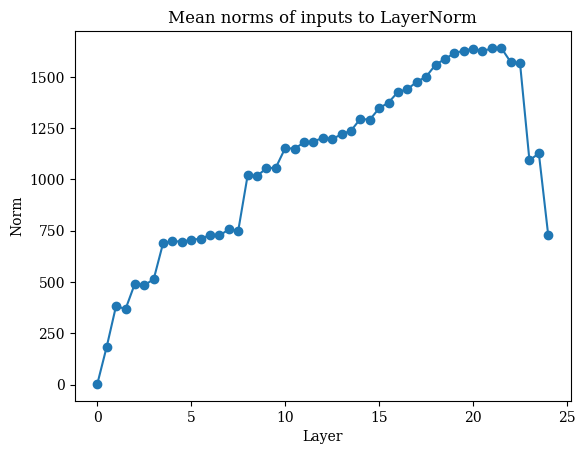

In [81]:
fig = plt.figure()
plt.title("Mean norms of inputs to LayerNorm")
plt.xlabel("Layer")
plt.ylabel("Norm")
plt.plot(np.arange(0,24.5,0.5), all_norms, marker='o')
plt.show()
fig.savefig("layernorm_norms.pdf", bbox_inches='tight')

In [65]:
mean_entries = []
for layer in range(len(model.transformer.h)):
    ln_1_norms = []
    ln_2_norms = []
    for i in range(len(subj_embeddings_female)):
        for j in range(3):
            ln_1_norms.append(np.mean(np.abs(subj_embeddings_female[j][i]['layers'][layer]['ln_1_in'][0])))
            ln_1_norms.append(np.mean(np.abs(subj_embeddings_male[j][i]['layers'][layer]['ln_1_in'][0])))
            ln_2_norms.append(np.mean(np.abs(subj_embeddings_female[j][i]['layers'][layer]['ln_2_in'][0])))
            ln_2_norms.append(np.mean(np.abs(subj_embeddings_male[j][i]['layers'][layer]['ln_2_in'][0])))
    mean_entries.append(np.mean(ln_1_norms))
    mean_entries.append(np.mean(ln_2_norms))
ln_f_norms = []
for i in range(len(subj_embeddings_female)):
    for j in range(3):
        ln_f_norms.append(np.mean(np.abs(subj_embeddings_female[j][i]['ln_f_in'][0])))
        ln_f_norms.append(np.mean(np.abs(subj_embeddings_male[j][i]['ln_f_in'][0])))
mean_entries.append(np.mean(ln_f_norms))

In [67]:
variance_to_mean_entry_ratio = np.array(variances)/np.array(mean_entries)

In [82]:
variance_to_mean_entry_ratio[0]

0.07145301

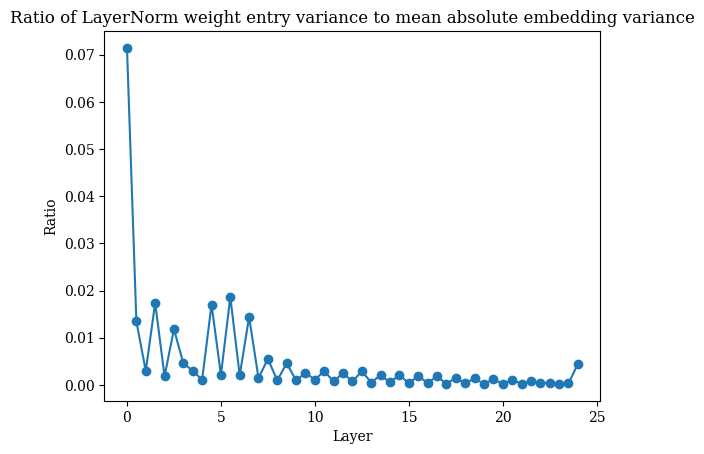

In [83]:
fig = plt.figure()
plt.title("Ratio of LayerNorm weight entry variance to mean absolute embedding variance")
plt.ylabel("Ratio")
plt.xlabel("Layer")
plt.plot(np.arange(0,24.5,0.5), variance_to_mean_entry_ratio, marker='o')
plt.show()
fig.savefig("layernorm_variances.pdf", bbox_inches='tight')

## Accuracies of `ln_f` approximations across prompt groups

In [73]:
subj_range_normal = make_range_normal([' she'], [' he'])

torch.Size([50257])


/tmp/ipykernel_24314/3127716323.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  n = n.T.to("cuda", dtype=torch.float32)


In [128]:
zeros = torch.zeros(subj_range_normal.shape).to("cuda")

### Subject prompt group 0


In [137]:
subj_ln_f_xpos_prompts0 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_female[0]])/len(subj_embeddings_female[0])
).to("cuda")[0]
subj_ln_f_xneg_prompts0 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_male[0]])/len(subj_embeddings_female[0])
).to("cuda")[0]

In [143]:
subj_ln_f_affine_prompts0 = domain_boundary_intersection(subj_ln_f_xpos_prompts0, subj_ln_f_xneg_prompts0,
                                                model.transformer.ln_f, subj_range_normal, zeros, lr=0.02, eps=0.0000001)
subj_ln_f_normal_prompts0 = get_tangent_plane_given_point(subj_ln_f_affine_prompts0, model.transformer.ln_f, subj_range_normal, zeros)

Final loss: 7.581412830859335e-08
Final t: tensor([0.4646], device='cuda:0', requires_grad=True)
4.037406583279335e-06


In [142]:
def mean_absolute_loss(f, embeddings_list, layer, sublayer, dom_normal, dom_affine, range_normal, range_affine, token=-1):
    avg_diff_sum = 0
    avg_diff_count = 0
    for np_embeddings in embeddings_list:
        embeddings = embeddings_np_to_torch(np_embeddings, free=False)
        if layer is None:
            my_point = embeddings[sublayer][:, token, :]
        else:
            my_point = embeddings['layers'][layer][sublayer][:, token, :]
        with torch.no_grad():
            avg_diff_sum += torch.abs(( (f(my_point) - range_affine) @ range_normal) - ((my_point-dom_affine) @ dom_normal)).item()
        avg_diff_count += 1
        free_embeddings(embeddings)
    return avg_diff_sum/avg_diff_count

In [145]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[0]+subj_embeddings_male[0],
                   None, 'ln_f_in', subj_ln_f_normal_prompts0, subj_ln_f_affine_prompts0, subj_range_normal, zeros, -1)

0.050001001358032225

The above means that for prompts in "Subject Prompt Group 0", the tangent plane that we found for Subject Prompt Group 0 has an average absolute error of 0.05 logits. Not bad!

In [146]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[1]+subj_embeddings_male[1],
                   None, 'ln_f_in', subj_ln_f_normal_prompts0, subj_ln_f_affine_prompts0, subj_range_normal, zeros, -1)

0.2946632385253906

But for prompts in Subject Prompt Group 1, this jumps up to 0.295 logits.

In [147]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[2]+subj_embeddings_male[2],
                   None, 'ln_f_in', subj_ln_f_normal_prompts0, subj_ln_f_affine_prompts0, subj_range_normal, zeros, -1)

0.2518632411956787

Suject Prompt Group 2. 0.252 logits.

### Subject prompt group 1

In [148]:
subj_ln_f_xpos_prompts1 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_female[1]])/len(subj_embeddings_female[1])
).to("cuda")[0]
subj_ln_f_xneg_prompts1 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_male[1]])/len(subj_embeddings_female[1])
).to("cuda")[0]

In [149]:
subj_ln_f_affine_prompts1 = domain_boundary_intersection(subj_ln_f_xpos_prompts1, subj_ln_f_xneg_prompts1,
                                                model.transformer.ln_f, subj_range_normal, zeros, lr=0.02, eps=0.0000001)
subj_ln_f_normal_prompts1 = get_tangent_plane_given_point(subj_ln_f_affine_prompts1, model.transformer.ln_f, subj_range_normal, zeros)

Final loss: 4.8557811993532596e-08
Final t: tensor([0.5460], device='cuda:0', requires_grad=True)
4.790950352884238e-06


In [150]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[0]+subj_embeddings_male[0],
                   None, 'ln_f_in', subj_ln_f_normal_prompts1, subj_ln_f_affine_prompts1, subj_range_normal, zeros, -1)

0.1448301076889038

In [151]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[1]+subj_embeddings_male[1],
                   None, 'ln_f_in', subj_ln_f_normal_prompts1, subj_ln_f_affine_prompts1, subj_range_normal, zeros, -1)

0.09488174915313721

In [152]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[2]+subj_embeddings_male[2],
                   None, 'ln_f_in', subj_ln_f_normal_prompts1, subj_ln_f_affine_prompts1, subj_range_normal, zeros, -1)

0.13128716945648194

### Subject prompt group 2

In [153]:
subj_ln_f_xpos_prompts2 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_female[2]])/len(subj_embeddings_female[2])
).to("cuda")[0]
subj_ln_f_xneg_prompts2 = torch.from_numpy(
    sum([x['ln_f_in'][:, -1, :] for x in subj_embeddings_male[2]])/len(subj_embeddings_female[2])
).to("cuda")[0]

In [154]:
subj_ln_f_affine_prompts2 = domain_boundary_intersection(subj_ln_f_xpos_prompts2, subj_ln_f_xneg_prompts2,
                                                model.transformer.ln_f, subj_range_normal, zeros, lr=0.02, eps=0.0000001)
subj_ln_f_normal_prompts2 = get_tangent_plane_given_point(subj_ln_f_affine_prompts2, model.transformer.ln_f, subj_range_normal, zeros)

Final loss: 6.809445096678246e-08
Final t: tensor([0.4901], device='cuda:0', requires_grad=True)
3.847786261701458e-05


In [155]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[0]+subj_embeddings_male[0],
                   None, 'ln_f_in', subj_ln_f_normal_prompts2, subj_ln_f_affine_prompts2, subj_range_normal, zeros, -1)

0.18031926155090333

In [156]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[1]+subj_embeddings_male[1],
                   None, 'ln_f_in', subj_ln_f_normal_prompts2, subj_ln_f_affine_prompts2, subj_range_normal, zeros, -1)

0.05655231475830078

In [157]:
mean_absolute_loss(model.transformer.ln_f, subj_embeddings_female[2]+subj_embeddings_male[2],
                   None, 'ln_f_in', subj_ln_f_normal_prompts2, subj_ln_f_affine_prompts2, subj_range_normal, zeros, -1)

0.05453193187713623

## Investigate feature vectors

In [167]:
cossim(subj_ln_f_normal_prompts0, subj_ln_f_normal_prompts1).item()

0.9999997019767761

In [169]:
print("Cossim 0 to 1", cossim(subj_ln_f_normal_prompts0, subj_ln_f_normal_prompts1).item())
print("Cossim 1 to 2", cossim(subj_ln_f_normal_prompts1, subj_ln_f_normal_prompts2).item())
print("Cossim 2 to 0", cossim(subj_ln_f_normal_prompts0, subj_ln_f_normal_prompts2).item())

Cossim 0 to 1 0.9999997019767761
Cossim 1 to 2 0.9999980926513672
Cossim 2 to 0 0.9999980330467224


In [162]:
torch.linalg.norm(subj_ln_f_normal_prompts0), torch.linalg.norm(subj_ln_f_normal_prompts1), torch.linalg.norm(subj_ln_f_normal_prompts2)

(tensor(0.2662, device='cuda:0'),
 tensor(0.2571, device='cuda:0'),
 tensor(0.2554, device='cuda:0'))

### 17.14

In [158]:
attn17_14_subj_normal_prompts0 = get_attn_normal(model, 17, 14, subj_ln_f_normal_prompts0)
attn17_14_subj_normal_prompts1 = get_attn_normal(model, 17, 14, subj_ln_f_normal_prompts1)
attn17_14_subj_normal_prompts2 = get_attn_normal(model, 17, 14, subj_ln_f_normal_prompts2)

In [159]:
print("Cosine similarity 0 to 1: ", cossim(attn17_14_subj_normal_prompts0, attn17_14_subj_normal_prompts1))
print("Cosine similarity 1 to 2: ", cossim(attn17_14_subj_normal_prompts2, attn17_14_subj_normal_prompts1))
print("Cosine similarity 2 to 0: ", cossim(attn17_14_subj_normal_prompts0, attn17_14_subj_normal_prompts2))

Cosine similarity 0 to 1:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity 1 to 2:  tensor(1.0000, device='cuda:0', grad_fn=<DivBackward0>)
Cosine similarity 2 to 0:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)


In [165]:
torch.linalg.norm(attn17_14_subj_normal_prompts0),\
torch.linalg.norm(attn17_14_subj_normal_prompts1),\
torch.linalg.norm(attn17_14_subj_normal_prompts2)

(tensor(8.8101, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(8.5090, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(8.4536, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>))

In [166]:
print("0, 1 coupling: ", coupling_coeff(attn17_14_subj_normal_prompts0, attn17_14_subj_normal_prompts1))
print("0, 2 coupling: ", coupling_coeff(attn17_14_subj_normal_prompts0, attn17_14_subj_normal_prompts2))
print("1, 2 coupling: ", coupling_coeff(attn17_14_subj_normal_prompts1, attn17_14_subj_normal_prompts2))

0, 1 coupling:  tensor(0.9658, device='cuda:0', grad_fn=<DivBackward0>)
0, 2 coupling:  tensor(0.9595, device='cuda:0', grad_fn=<DivBackward0>)
1, 2 coupling:  tensor(0.9935, device='cuda:0', grad_fn=<DivBackward0>)
